In [97]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    roc_auc_score, roc_curve, auc,
    ConfusionMatrixDisplay, RocCurveDisplay,
    PrecisionRecallDisplay, precision_recall_curve,
    make_scorer, average_precision_score,
    f1_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization, Input
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import AUC
from keras_tuner import HyperModel, RandomSearch, Objective
from scikeras.wrappers import KerasClassifier



from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.under_sampling import RandomUnderSampler

from itertools import product
# from skimpy import skim


In [2]:
df_train = pd.read_csv("../data/train.csv")

In [3]:
df_test = pd.read_csv("../data/test.csv")

## Converting categorical data to numeric features and normalising

In [4]:
columns_to_encode = ['home_ownership','verification_status','purpose','application_type','sub_grade']

In [5]:
# One-hot encoding 
df_train = pd.get_dummies(df_train, columns=columns_to_encode)
df_test = pd.get_dummies(df_test, columns=columns_to_encode)

In [6]:
target_column = 'loan_status'  # Replace with your actual target variable name

class_mapping = {'Fully Paid': 0, 'Charged Off': 1}  

# Apply binary encoding to the target variable in the training DataFrame
df_train['Label'] = df_train[target_column].map(class_mapping)
df_test['Label'] = df_test[target_column].map(class_mapping)

In [7]:
print(df_train.shape)
print(df_train['Label'].value_counts(normalize=True) * 100)
print(df_test.shape)
print(df_test['Label'].value_counts(normalize=True) * 100)

(223591, 73)
Label
0    80.224159
1    19.775841
Name: proportion, dtype: float64
(112456, 74)
Label
0    80.279398
1    19.720602
Name: proportion, dtype: float64


In [8]:
df_train['purpose_educational'] = False


In [9]:
train_columns = df_train.columns
test_columns = df_test.columns

if set(train_columns) == set(test_columns):
    print("All columns match.")
else:
    print("Columns do not match.")


All columns match.


In [10]:
X_train = df_train.drop(['Label','loan_status'], axis=1)
y_train = df_train['Label']
X_test = df_test.drop(['Label','loan_status'], axis=1)
y_test = df_test['Label']
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

In [11]:
scaler = RobustScaler()
X_train_robust = scaler.fit_transform(X_train)
X_test_robust = scaler.transform(X_test)

scaler = StandardScaler()
X_train_standard = scaler.fit_transform(X_train)
X_test_standard = scaler.transform(X_test)

scaler = MinMaxScaler()
X_train_minmax = scaler.fit_transform(X_train)
X_test_minmax = scaler.transform(X_test)

In [12]:
def evaluate_nn(true, pred_probs, train=True):
    # For binary classification problems, threshold probabilities at 0.5 to get class predictions
    pred_class = (pred_probs > 0.5).astype(int)

    auprc_base = average_precision_score(true, pred_probs)

    if train:
        print("Train Result:\n================================================")
    else:
        print("Test Result:\n================================================")

    acc = accuracy_score(true, pred_class) * 100
    clf_report = pd.DataFrame(classification_report(true, pred_class, output_dict=True))
    cm = confusion_matrix(true, pred_class)

    print(f"Accuracy Score: {acc:.2f}%")
    print("_______________________________________________")
    print(f"CLASSIFICATION REPORT:\n{clf_report}")
    print("_______________________________________________")
    print(f"Confusion Matrix: \n {cm}\n")
    print(f"Area Under the Precision-Recall Curve (AUPRC): {auprc_base:.4f}")


In [13]:
def plot_learning_evolution(r):
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.plot(r.history['loss'], label='Loss')
    plt.plot(r.history['val_loss'], label='val_Loss')
    plt.title('Loss evolution during trainig')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(r.history['AUC'], label='AUC')
    plt.plot(r.history['val_AUC'], label='val_AUC')
    plt.title('AUC score evolution during trainig')
    plt.legend();

## Basic Models

In [14]:
model = Sequential()

model.add(Dense(100,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(100,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(100,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=[AUC(name='AUC')])

#### robust_basic

In [15]:
r_robust = model.fit(x=X_train_robust, y=y_train, epochs=20,verbose = 2,batch_size=32, validation_data=(X_test_robust, y_test))

Epoch 1/20
6988/6988 - 7s - 1ms/step - AUC: 0.7885 - loss: 0.3800 - val_AUC: 0.8035 - val_loss: 0.3607
Epoch 2/20
6988/6988 - 6s - 880us/step - AUC: 0.8470 - loss: 0.3259 - val_AUC: 0.8823 - val_loss: 0.2848
Epoch 3/20
6988/6988 - 6s - 880us/step - AUC: 0.8810 - loss: 0.2868 - val_AUC: 0.8828 - val_loss: 0.2856
Epoch 4/20
6988/6988 - 6s - 882us/step - AUC: 0.8838 - loss: 0.2830 - val_AUC: 0.8852 - val_loss: 0.2784
Epoch 5/20
6988/6988 - 6s - 871us/step - AUC: 0.8849 - loss: 0.2816 - val_AUC: 0.8861 - val_loss: 0.2789
Epoch 6/20
6988/6988 - 6s - 864us/step - AUC: 0.8864 - loss: 0.2801 - val_AUC: 0.8862 - val_loss: 0.2788
Epoch 7/20
6988/6988 - 6s - 859us/step - AUC: 0.8871 - loss: 0.2806 - val_AUC: 0.8864 - val_loss: 0.2793
Epoch 8/20
6988/6988 - 6s - 859us/step - AUC: 0.8882 - loss: 0.2788 - val_AUC: 0.8865 - val_loss: 0.2787
Epoch 9/20
6988/6988 - 6s - 853us/step - AUC: 0.8890 - loss: 0.2773 - val_AUC: 0.8867 - val_loss: 0.2797
Epoch 10/20
6988/6988 - 6s - 865us/step - AUC: 0.8895 - l

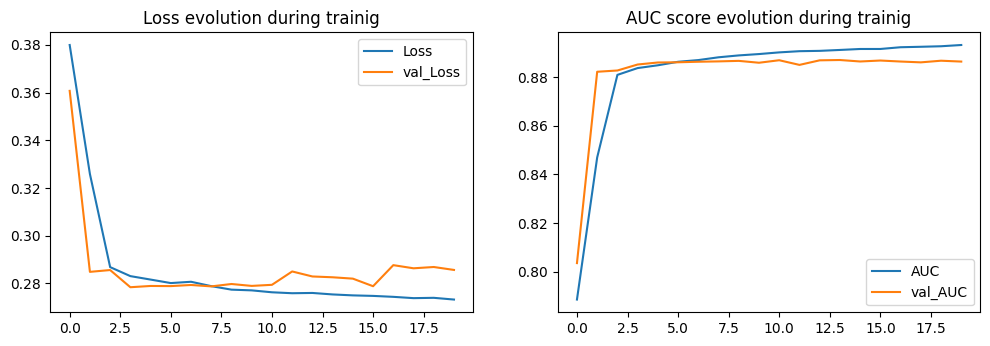

In [16]:
plot_learning_evolution(r_robust)                                                                                 

In [17]:
y_test_pred_robust = model.predict(X_test_robust)
evaluate_nn(y_test, y_test_pred_robust, train=False)

3515/3515 ━━━━━━━━━━━━━━━━━━━━ 2s 426us/step
Test Result:
Accuracy Score: 88.69%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.879797      0.956539  0.886862       0.918168       0.894931
recall         0.995015      0.446589  0.886862       0.720802       0.886862
f1-score       0.933866      0.608896  0.886862       0.771381       0.869780
support    90279.000000  22177.000000  0.886862  112456.000000  112456.000000
_______________________________________________
Confusion Matrix: 
 [[89829   450]
 [12273  9904]]

Area Under the Precision-Recall Curve (AUPRC): 0.7581


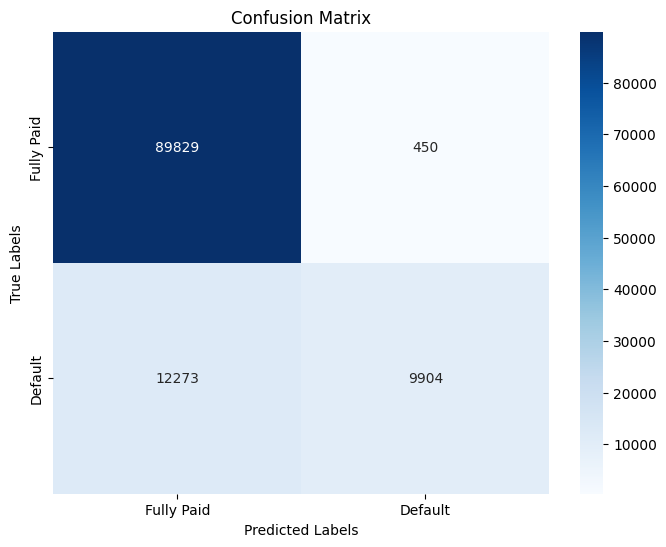

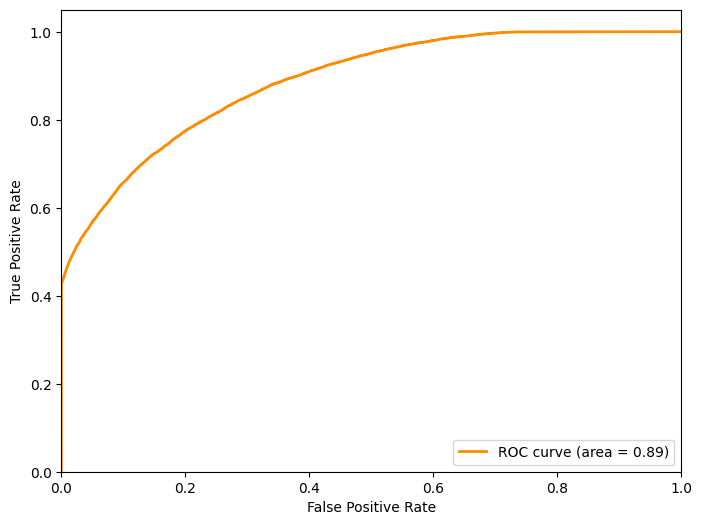

0.5749533642603611


In [18]:
y_pred_op = (y_test_pred_robust > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred_op)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Fully Paid', 'Default'])
ax.yaxis.set_ticklabels(['Fully Paid', 'Default'])
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_test_pred_robust)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_robust)

# Calculate Kolmogorov-Smirnov measure (KS)
ks = max(tpr - fpr)

print(ks)

#### standard_basic

In [19]:
r_standard = model.fit(x=X_train_standard, y=y_train, epochs=20,verbose = 2,batch_size=32, validation_data=(X_test_standard, y_test))

Epoch 1/20
6988/6988 - 6s - 880us/step - AUC: 0.8182 - loss: 0.4361 - val_AUC: 0.8717 - val_loss: 0.3013
Epoch 2/20
6988/6988 - 6s - 870us/step - AUC: 0.8680 - loss: 0.3085 - val_AUC: 0.8770 - val_loss: 0.2921
Epoch 3/20
6988/6988 - 6s - 859us/step - AUC: 0.8749 - loss: 0.2979 - val_AUC: 0.8787 - val_loss: 0.2910
Epoch 4/20
6988/6988 - 6s - 858us/step - AUC: 0.8789 - loss: 0.2929 - val_AUC: 0.8810 - val_loss: 0.2869
Epoch 5/20
6988/6988 - 6s - 856us/step - AUC: 0.8806 - loss: 0.2897 - val_AUC: 0.8817 - val_loss: 0.2859
Epoch 6/20
6988/6988 - 6s - 854us/step - AUC: 0.8834 - loss: 0.2869 - val_AUC: 0.8841 - val_loss: 0.2832
Epoch 7/20
6988/6988 - 6s - 857us/step - AUC: 0.8848 - loss: 0.2848 - val_AUC: 0.8845 - val_loss: 0.2818
Epoch 8/20
6988/6988 - 6s - 855us/step - AUC: 0.8854 - loss: 0.2839 - val_AUC: 0.8850 - val_loss: 0.2822
Epoch 9/20
6988/6988 - 6s - 853us/step - AUC: 0.8861 - loss: 0.2829 - val_AUC: 0.8841 - val_loss: 0.2834
Epoch 10/20
6988/6988 - 6s - 856us/step - AUC: 0.8864 -

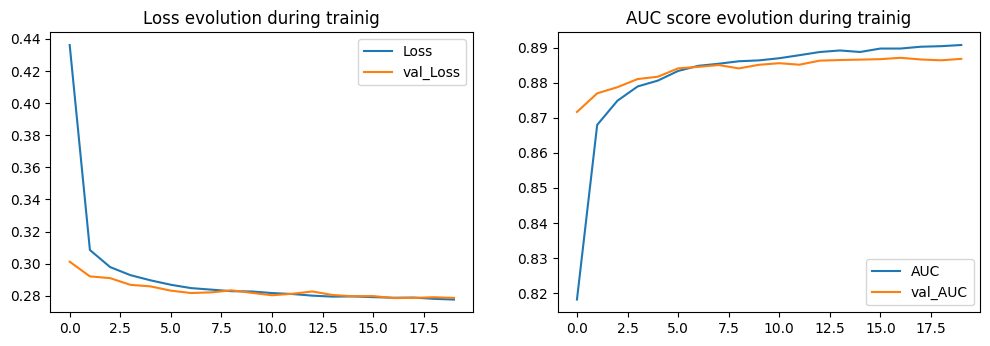

In [20]:
plot_learning_evolution(r_standard)

In [21]:
y_test_pred_standard = model.predict(X_test_standard)
evaluate_nn(y_test, y_test_pred_standard, train=False)

3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 415us/step
Test Result:
Accuracy Score: 88.62%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.879984      0.947118  0.886249       0.913551       0.893223
recall         0.993852      0.448212  0.886249       0.721032       0.886249
f1-score       0.933458      0.608472  0.886249       0.770965       0.869369
support    90279.000000  22177.000000  0.886249  112456.000000  112456.000000
_______________________________________________
Confusion Matrix: 
 [[89724   555]
 [12237  9940]]

Area Under the Precision-Recall Curve (AUPRC): 0.7581


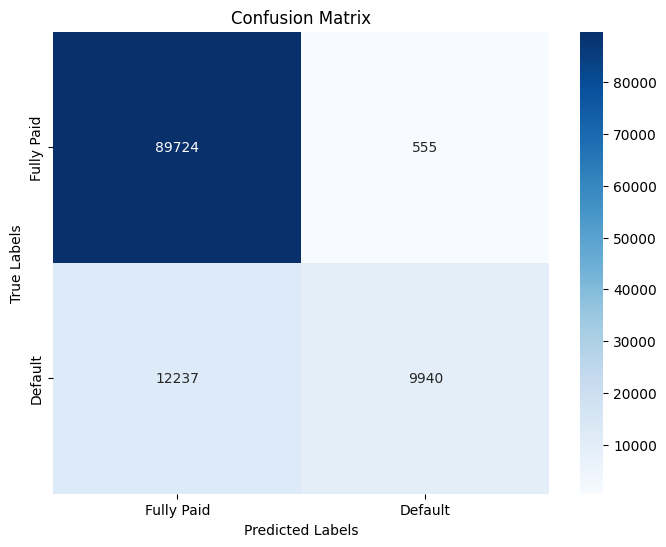

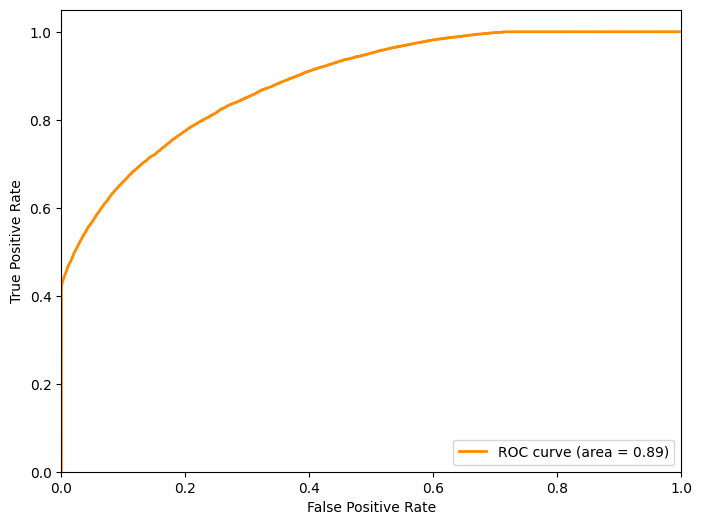

0.5755559817743213


In [22]:
y_pred_op = (y_test_pred_standard > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred_op)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Fully Paid', 'Default'])
ax.yaxis.set_ticklabels(['Fully Paid', 'Default'])
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_test_pred_standard)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_standard)

# Calculate Kolmogorov-Smirnov measure (KS)
ks = max(tpr - fpr)

print(ks)

#### minmax_basic

In [23]:
r_minmax = model.fit(x=X_train_minmax, y=y_train, epochs=20,verbose = 2,batch_size=32, validation_data=(X_test_minmax, y_test))

Epoch 1/20
6988/6988 - 6s - 867us/step - AUC: 0.7935 - loss: 0.3720 - val_AUC: 0.8341 - val_loss: 0.3410
Epoch 2/20
6988/6988 - 6s - 861us/step - AUC: 0.8475 - loss: 0.3283 - val_AUC: 0.8749 - val_loss: 0.2943
Epoch 3/20
6988/6988 - 6s - 852us/step - AUC: 0.8719 - loss: 0.2989 - val_AUC: 0.8825 - val_loss: 0.2847
Epoch 4/20
6988/6988 - 6s - 858us/step - AUC: 0.8776 - loss: 0.2899 - val_AUC: 0.8842 - val_loss: 0.2817
Epoch 5/20
6988/6988 - 6s - 853us/step - AUC: 0.8807 - loss: 0.2854 - val_AUC: 0.8846 - val_loss: 0.2796
Epoch 6/20
6988/6988 - 6s - 865us/step - AUC: 0.8826 - loss: 0.2828 - val_AUC: 0.8856 - val_loss: 0.2787
Epoch 7/20
6988/6988 - 6s - 859us/step - AUC: 0.8844 - loss: 0.2804 - val_AUC: 0.8854 - val_loss: 0.2790
Epoch 8/20
6988/6988 - 6s - 850us/step - AUC: 0.8845 - loss: 0.2804 - val_AUC: 0.8854 - val_loss: 0.2795
Epoch 9/20
6988/6988 - 6s - 849us/step - AUC: 0.8854 - loss: 0.2793 - val_AUC: 0.8862 - val_loss: 0.2802
Epoch 10/20
6988/6988 - 6s - 845us/step - AUC: 0.8866 -

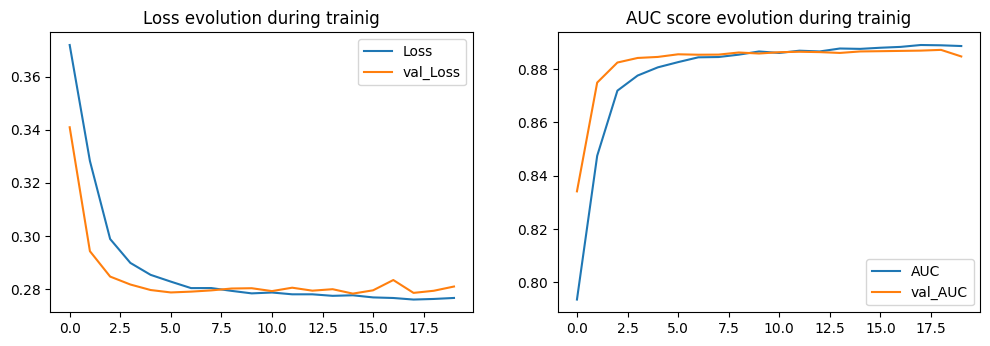

In [24]:
plot_learning_evolution(r_minmax)

In [25]:
y_test_pred_minmax = model.predict(X_test_minmax)
evaluate_nn(y_test, y_test_pred_minmax, train=False)

3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 416us/step
Test Result:
Accuracy Score: 88.74%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.878372      0.980398  0.887351       0.929385       0.898493
recall         0.997851      0.437525  0.887351       0.717688       0.887351
f1-score       0.934308      0.605038  0.887351       0.769673       0.869374
support    90279.000000  22177.000000  0.887351  112456.000000  112456.000000
_______________________________________________
Confusion Matrix: 
 [[90085   194]
 [12474  9703]]

Area Under the Precision-Recall Curve (AUPRC): 0.7581


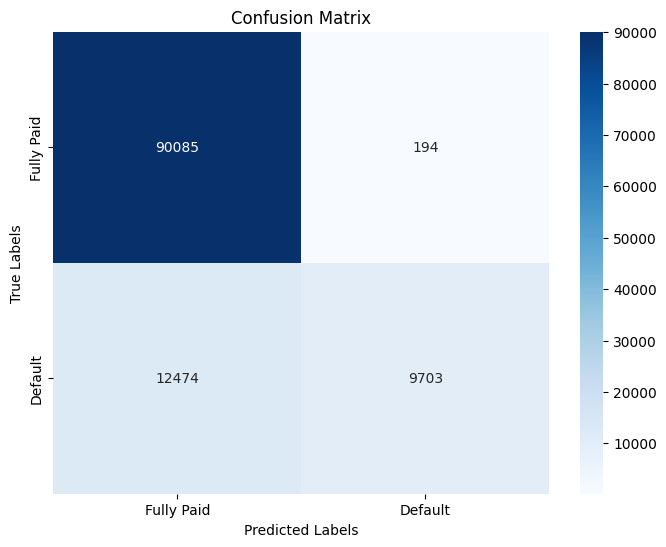

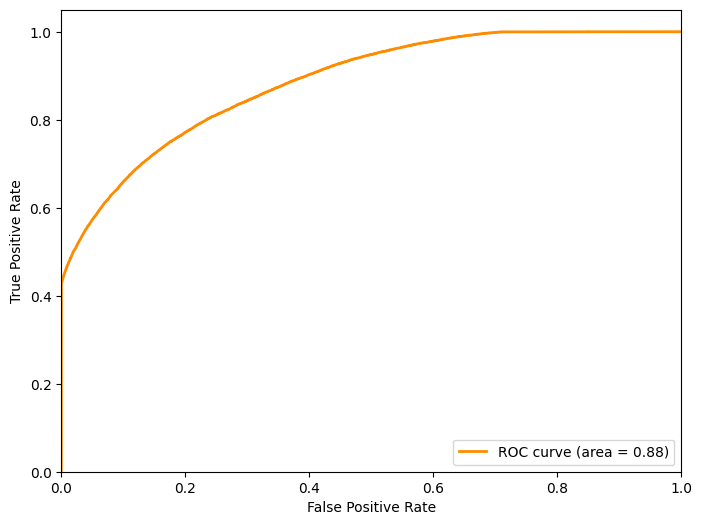

0.574405094209204


In [115]:
y_pred_op = (y_test_pred_minmax > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred_op)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Fully Paid', 'Default'])
ax.yaxis.set_ticklabels(['Fully Paid', 'Default'])
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_test_pred_minmax)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_minmax)

# Calculate Kolmogorov-Smirnov measure (KS)
ks = max(tpr - fpr)

print(ks)

### overall PRC curves

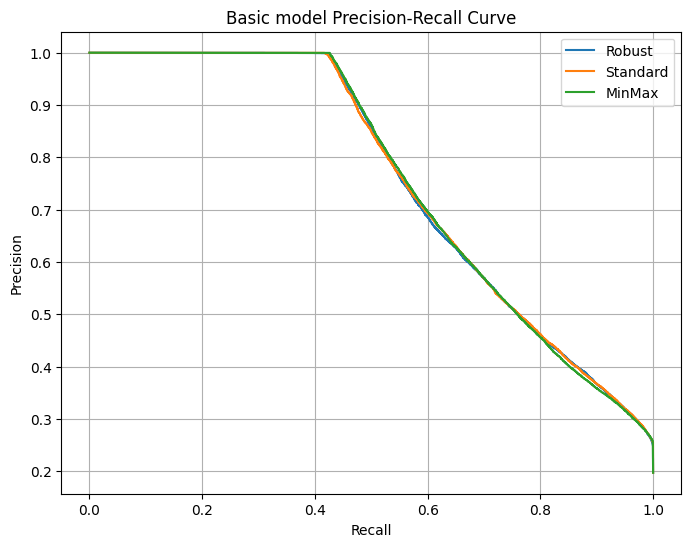

In [27]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

for y_pred, y_true, label in zip([y_test_pred_robust, y_test_pred_standard, y_test_pred_minmax],[y_test, y_test, y_test], ['Robust', 'Standard', 'MinMax']):
    # Compute precision-recall curve
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    
    # Plot precision-recall curve
    plt.plot(recall, precision, label=label)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Basic model Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

# Optimise by looping

In [108]:
def create_model_loop(n_units, dropout_rate, learning_rate):
    model = Sequential()
    model.add(Dense(n_units, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_units // 2, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate),
                  loss='binary_crossentropy',
                  metrics=[AUC(name='AUC')])  # Modify metrics as per your requirement
    return model

In [128]:
def evaluate_nn_op(true, pred_probs, train=True):
    # Predict class labels based on the probability threshold
    pred_class = (pred_probs > 0.5).astype(int)

    # Compute the Area Under the Precision-Recall Curve (AUPRC)
    auprc_base = average_precision_score(true, pred_probs)

    # Calculate accuracy and other classification metrics
    acc = accuracy_score(true, pred_class) * 100
    clf_report = classification_report(true, pred_class, output_dict=True)
    cm = confusion_matrix(true, pred_class)

    # Prepare results with detailed metrics for both classes
    results = {
        "Phase": "Train" if train else "Test",
        "Overall Accuracy": acc,
        "Class 0 Precision": clf_report['0']['precision'],
        "Class 0 Recall": clf_report['0']['recall'],
        "Class 0 F1-Score": clf_report['0']['f1-score'],
        "Class 1 Precision": clf_report['1']['precision'],
        "Class 1 Recall": clf_report['1']['recall'],
        "Class 1 F1-Score": clf_report['1']['f1-score'],
        "Confusion Matrix": cm.tolist(),  # Convert numpy array to list
        "AUPRC": auprc_base
    }

    return results

In [129]:
param_grid = {
    'classifier__n_units': [32, 64, 128, 256],
    'classifier__dropout_rate': [0.1, 0.2, 0.5],
    'classifier__learning_rate': [0.01, 0.001, 0.0001]
}

In [130]:
param_combinations = list(product(param_grid['classifier__n_units'], 
                                  param_grid['classifier__dropout_rate'], 
                                  param_grid['classifier__learning_rate']))

results_list = []

# Assuming param_combinations is a list of tuples, each with (n_units, dropout_rate, learning_rate)
for n_units, dropout_rate, learning_rate in param_combinations:
    # Create and train the model
    model = create_model_loop(n_units=n_units, dropout_rate=dropout_rate, learning_rate=learning_rate)
    model.fit(X_train_minmax, y_train, epochs=10, batch_size=32, verbose=0)

    # Predict probabilities on the test set
    y_test_pred_probs = model.predict(X_test_minmax)[:, 0]  # Ensure correct indexing if model.predict returns a 2D array

    # Evaluate the model on the test data and collect results
    test_results = evaluate_nn_op(y_test, y_test_pred_probs, train=False)
    results_list.append(test_results)

c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 393us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 393us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 391us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 398us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 392us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 393us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 397us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 407us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 406us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 2s 426us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 2s 419us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 408us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 407us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 415us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 2s 436us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 399us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 415us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 414us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 416us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 2s 433us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 2s 422us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 2s 419us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 411us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 2s 429us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 2s 419us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 415us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 2s 424us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 2s 439us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 2s 433us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 2s 443us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 2s 449us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 2s 434us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 2s 444us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 2s 434us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 2s 447us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 2s 434us/step


In [131]:
results_df = pd.DataFrame(results_list)
results_df.to_csv('model_evaluation_results.csv', index=False)

# undersampling by looping

In [132]:
rus = RandomUnderSampler(random_state=42)

In [133]:
X_under, y_under = rus.fit_resample(X_train_minmax, y_train)

In [134]:
param_combinations = list(product(param_grid['classifier__n_units'], 
                                  param_grid['classifier__dropout_rate'], 
                                  param_grid['classifier__learning_rate']))

results_list_under = []

# Assuming param_combinations is a list of tuples, each with (n_units, dropout_rate, learning_rate)
for n_units, dropout_rate, learning_rate in param_combinations:
    # Create and train the model
    model = create_model_loop(n_units=n_units, dropout_rate=dropout_rate, learning_rate=learning_rate)
    model.fit(X_under, y_under, epochs=10, batch_size=32, verbose=0)

    # Predict probabilities on the test set
    y_test_pred_probs = model.predict(X_test_minmax)[:, 0]  # Ensure correct indexing if model.predict returns a 2D array

    # Evaluate the model on the test data and collect results
    test_results = evaluate_nn_op(y_test, y_test_pred_probs, train=False)
    results_list_under.append(test_results)

c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 415us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 2s 428us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 410us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 400us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 403us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 389us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 401us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 389us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 386us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 386us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 386us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 382us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 401us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 383us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 384us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 400us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 396us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 396us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 401us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 395us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 402us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 403us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 394us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 390us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 390us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 409us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 2s 419us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 2s 420us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 2s 428us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 2s 439us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 2s 441us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 2s 427us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 2s 425us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 2s 426us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 2s 437us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 2s 434us/step


In [135]:
results_under_df = pd.DataFrame(results_list_under)
results_under_df.to_csv('model_evaluation_results_under.csv', index=False)

# Optimisation with RandomSearchCV

## F1- weighted

only using minmax scaling

In [28]:
def create_model(n_units=32, dropout_rate=0.1, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(n_units, activation='relu', input_shape=(X_train_minmax.shape[1],)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_units // 2, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy', metrics=['AUC'])
    return model


In [34]:
keras_clf = KerasClassifier(build_fn=create_model, epochs=20, batch_size=32, verbose=2,
                             n_units=32, dropout_rate=0.1, learning_rate=0.001)

In [35]:
pipeline = Pipeline([
    ('classifier', keras_clf)
])

In [36]:
param_grid = {
    'classifier__n_units': [32, 64, 128, 256],
    'classifier__dropout_rate': [0.1, 0.2, 0.3, 0.5],
    'classifier__learning_rate': [0.01, 0.001, 0.0001]
}

In [37]:
nn_tuning_f1 = RandomizedSearchCV(estimator=pipeline,
                                   param_distributions=param_grid,
                                   n_iter=8,
                                   cv=3,
                                   random_state=42,
                                   scoring='f1_weighted')

r_nn_tuning_f1= nn_tuning_f1.fit(X_train_minmax, y_train)

Epoch 1/20


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4659/4659 - 4s - 805us/step - AUC: 0.7762 - loss: 0.3940
Epoch 2/20
4659/4659 - 3s - 671us/step - AUC: 0.7888 - loss: 0.3743
Epoch 3/20
4659/4659 - 3s - 659us/step - AUC: 0.8184 - loss: 0.3535
Epoch 4/20
4659/4659 - 3s - 652us/step - AUC: 0.8217 - loss: 0.3500
Epoch 5/20
4659/4659 - 3s - 661us/step - AUC: 0.8227 - loss: 0.3491
Epoch 6/20
4659/4659 - 3s - 663us/step - AUC: 0.8222 - loss: 0.3492
Epoch 7/20
4659/4659 - 3s - 677us/step - AUC: 0.8206 - loss: 0.3498
Epoch 8/20
4659/4659 - 3s - 652us/step - AUC: 0.8219 - loss: 0.3493
Epoch 9/20
4659/4659 - 3s - 664us/step - AUC: 0.8229 - loss: 0.3485
Epoch 10/20
4659/4659 - 3s - 662us/step - AUC: 0.8226 - loss: 0.3476
Epoch 11/20
4659/4659 - 3s - 653us/step - AUC: 0.8208 - loss: 0.3491
Epoch 12/20
4659/4659 - 3s - 657us/step - AUC: 0.8220 - loss: 0.3487
Epoch 13/20
4659/4659 - 3s - 662us/step - AUC: 0.8222 - loss: 0.3487
Epoch 14/20
4659/4659 - 3s - 665us/step - AUC: 0.8224 - loss: 0.3479
Epoch 15/20
4659/4659 - 3s - 667us/step - AUC: 0.8234 

c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4659/4659 - 4s - 813us/step - AUC: 0.7727 - loss: 0.3957
Epoch 2/20
4659/4659 - 3s - 660us/step - AUC: 0.7876 - loss: 0.3751
Epoch 3/20
4659/4659 - 3s - 663us/step - AUC: 0.8144 - loss: 0.3562
Epoch 4/20
4659/4659 - 3s - 668us/step - AUC: 0.8179 - loss: 0.3526
Epoch 5/20
4659/4659 - 3s - 660us/step - AUC: 0.8188 - loss: 0.3516
Epoch 6/20
4659/4659 - 3s - 663us/step - AUC: 0.8201 - loss: 0.3498
Epoch 7/20
4659/4659 - 3s - 667us/step - AUC: 0.8204 - loss: 0.3503
Epoch 8/20
4659/4659 - 3s - 665us/step - AUC: 0.8203 - loss: 0.3502
Epoch 9/20
4659/4659 - 3s - 670us/step - AUC: 0.8197 - loss: 0.3506
Epoch 10/20
4659/4659 - 3s - 666us/step - AUC: 0.8213 - loss: 0.3489
Epoch 11/20
4659/4659 - 3s - 699us/step - AUC: 0.8206 - loss: 0.3482
Epoch 12/20
4659/4659 - 3s - 674us/step - AUC: 0.8195 - loss: 0.3506
Epoch 13/20
4659/4659 - 3s - 669us/step - AUC: 0.8209 - loss: 0.3491
Epoch 14/20
4659/4659 - 3s - 668us/step - AUC: 0.8215 - loss: 0.3487
Epoch 15/20
4659/4659 - 3s - 664us/step - AUC: 0.8202 

c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4659/4659 - 4s - 896us/step - AUC: 0.7737 - loss: 0.3950
Epoch 2/20
4659/4659 - 4s - 755us/step - AUC: 0.7856 - loss: 0.3769
Epoch 3/20
4659/4659 - 3s - 672us/step - AUC: 0.8116 - loss: 0.3586
Epoch 4/20
4659/4659 - 3s - 659us/step - AUC: 0.8173 - loss: 0.3538
Epoch 5/20
4659/4659 - 3s - 672us/step - AUC: 0.8183 - loss: 0.3529
Epoch 6/20
4659/4659 - 3s - 668us/step - AUC: 0.8180 - loss: 0.3521
Epoch 7/20
4659/4659 - 3s - 658us/step - AUC: 0.8191 - loss: 0.3517
Epoch 8/20
4659/4659 - 3s - 667us/step - AUC: 0.8182 - loss: 0.3525
Epoch 9/20
4659/4659 - 3s - 665us/step - AUC: 0.8192 - loss: 0.3511
Epoch 10/20
4659/4659 - 3s - 658us/step - AUC: 0.8204 - loss: 0.3501
Epoch 11/20
4659/4659 - 3s - 663us/step - AUC: 0.8186 - loss: 0.3516
Epoch 12/20
4659/4659 - 3s - 661us/step - AUC: 0.8190 - loss: 0.3517
Epoch 13/20
4659/4659 - 3s - 672us/step - AUC: 0.8187 - loss: 0.3519
Epoch 14/20
4659/4659 - 3s - 654us/step - AUC: 0.8194 - loss: 0.3513
Epoch 15/20
4659/4659 - 3s - 664us/step - AUC: 0.8186 

c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4659/4659 - 3s - 663us/step - AUC: 0.7340 - loss: 0.4409
Epoch 2/20
4659/4659 - 2s - 525us/step - AUC: 0.7772 - loss: 0.3979
Epoch 3/20
4659/4659 - 2s - 522us/step - AUC: 0.7830 - loss: 0.3881
Epoch 4/20
4659/4659 - 2s - 536us/step - AUC: 0.7870 - loss: 0.3848
Epoch 5/20
4659/4659 - 3s - 539us/step - AUC: 0.7870 - loss: 0.3841
Epoch 6/20
4659/4659 - 2s - 528us/step - AUC: 0.7896 - loss: 0.3823
Epoch 7/20
4659/4659 - 2s - 531us/step - AUC: 0.7905 - loss: 0.3808
Epoch 8/20
4659/4659 - 2s - 519us/step - AUC: 0.7914 - loss: 0.3804
Epoch 9/20
4659/4659 - 3s - 558us/step - AUC: 0.7954 - loss: 0.3783
Epoch 10/20
4659/4659 - 2s - 518us/step - AUC: 0.8041 - loss: 0.3729
Epoch 11/20
4659/4659 - 2s - 530us/step - AUC: 0.8080 - loss: 0.3677
Epoch 12/20
4659/4659 - 2s - 524us/step - AUC: 0.8100 - loss: 0.3650
Epoch 13/20
4659/4659 - 2s - 531us/step - AUC: 0.8096 - loss: 0.3644
Epoch 14/20
4659/4659 - 2s - 522us/step - AUC: 0.8115 - loss: 0.3623
Epoch 15/20
4659/4659 - 2s - 519us/step - AUC: 0.8118 

c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4659/4659 - 3s - 654us/step - AUC: 0.7392 - loss: 0.4365
Epoch 2/20
4659/4659 - 2s - 507us/step - AUC: 0.7800 - loss: 0.3907
Epoch 3/20
4659/4659 - 2s - 515us/step - AUC: 0.7877 - loss: 0.3780
Epoch 4/20
4659/4659 - 2s - 506us/step - AUC: 0.7931 - loss: 0.3738
Epoch 5/20
4659/4659 - 2s - 510us/step - AUC: 0.8071 - loss: 0.3657
Epoch 6/20
4659/4659 - 2s - 503us/step - AUC: 0.8206 - loss: 0.3534
Epoch 7/20
4659/4659 - 2s - 512us/step - AUC: 0.8225 - loss: 0.3515
Epoch 8/20
4659/4659 - 2s - 513us/step - AUC: 0.8241 - loss: 0.3499
Epoch 9/20
4659/4659 - 2s - 511us/step - AUC: 0.8250 - loss: 0.3495
Epoch 10/20
4659/4659 - 2s - 506us/step - AUC: 0.8269 - loss: 0.3481
Epoch 11/20
4659/4659 - 2s - 511us/step - AUC: 0.8277 - loss: 0.3487
Epoch 12/20
4659/4659 - 2s - 517us/step - AUC: 0.8299 - loss: 0.3468
Epoch 13/20
4659/4659 - 2s - 509us/step - AUC: 0.8308 - loss: 0.3453
Epoch 14/20
4659/4659 - 2s - 511us/step - AUC: 0.8322 - loss: 0.3440
Epoch 15/20
4659/4659 - 2s - 506us/step - AUC: 0.8333 

c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4659/4659 - 3s - 650us/step - AUC: 0.7309 - loss: 0.4422
Epoch 2/20
4659/4659 - 2s - 506us/step - AUC: 0.7777 - loss: 0.3949
Epoch 3/20
4659/4659 - 2s - 509us/step - AUC: 0.7872 - loss: 0.3809
Epoch 4/20
4659/4659 - 2s - 508us/step - AUC: 0.7920 - loss: 0.3757
Epoch 5/20
4659/4659 - 2s - 510us/step - AUC: 0.7921 - loss: 0.3757
Epoch 6/20
4659/4659 - 2s - 508us/step - AUC: 0.7955 - loss: 0.3729
Epoch 7/20
4659/4659 - 2s - 504us/step - AUC: 0.8059 - loss: 0.3667
Epoch 8/20
4659/4659 - 2s - 510us/step - AUC: 0.8177 - loss: 0.3584
Epoch 9/20
4659/4659 - 2s - 503us/step - AUC: 0.8214 - loss: 0.3536
Epoch 10/20
4659/4659 - 2s - 510us/step - AUC: 0.8230 - loss: 0.3520
Epoch 11/20
4659/4659 - 2s - 504us/step - AUC: 0.8240 - loss: 0.3503
Epoch 12/20
4659/4659 - 2s - 512us/step - AUC: 0.8246 - loss: 0.3501
Epoch 13/20
4659/4659 - 2s - 505us/step - AUC: 0.8257 - loss: 0.3489
Epoch 14/20
4659/4659 - 2s - 504us/step - AUC: 0.8259 - loss: 0.3480
Epoch 15/20
4659/4659 - 2s - 508us/step - AUC: 0.8265 

c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4659/4659 - 3s - 708us/step - AUC: 0.7745 - loss: 0.3943
Epoch 2/20
4659/4659 - 3s - 567us/step - AUC: 0.7888 - loss: 0.3742
Epoch 3/20
4659/4659 - 3s - 571us/step - AUC: 0.8131 - loss: 0.3578
Epoch 4/20
4659/4659 - 3s - 566us/step - AUC: 0.8308 - loss: 0.3432
Epoch 5/20
4659/4659 - 3s - 565us/step - AUC: 0.8324 - loss: 0.3418
Epoch 6/20
4659/4659 - 3s - 569us/step - AUC: 0.8333 - loss: 0.3403
Epoch 7/20
4659/4659 - 3s - 566us/step - AUC: 0.8337 - loss: 0.3400
Epoch 8/20
4659/4659 - 3s - 568us/step - AUC: 0.8347 - loss: 0.3394
Epoch 9/20
4659/4659 - 3s - 568us/step - AUC: 0.8360 - loss: 0.3390
Epoch 10/20
4659/4659 - 3s - 567us/step - AUC: 0.8364 - loss: 0.3382
Epoch 11/20
4659/4659 - 3s - 568us/step - AUC: 0.8392 - loss: 0.3360
Epoch 12/20
4659/4659 - 3s - 569us/step - AUC: 0.8449 - loss: 0.3287
Epoch 13/20
4659/4659 - 3s - 568us/step - AUC: 0.8500 - loss: 0.3206
Epoch 14/20
4659/4659 - 3s - 570us/step - AUC: 0.8460 - loss: 0.3262
Epoch 15/20
4659/4659 - 3s - 571us/step - AUC: 0.8457 

c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4659/4659 - 3s - 707us/step - AUC: 0.7758 - loss: 0.3936
Epoch 2/20
4659/4659 - 3s - 567us/step - AUC: 0.7879 - loss: 0.3751
Epoch 3/20
4659/4659 - 3s - 566us/step - AUC: 0.8053 - loss: 0.3632
Epoch 4/20
4659/4659 - 3s - 560us/step - AUC: 0.8306 - loss: 0.3426
Epoch 5/20
4659/4659 - 3s - 567us/step - AUC: 0.8329 - loss: 0.3414
Epoch 6/20
4659/4659 - 3s - 560us/step - AUC: 0.8336 - loss: 0.3399
Epoch 7/20
4659/4659 - 3s - 563us/step - AUC: 0.8330 - loss: 0.3406
Epoch 8/20
4659/4659 - 3s - 564us/step - AUC: 0.8332 - loss: 0.3411
Epoch 9/20
4659/4659 - 3s - 566us/step - AUC: 0.8342 - loss: 0.3398
Epoch 10/20
4659/4659 - 3s - 566us/step - AUC: 0.8356 - loss: 0.3387
Epoch 11/20
4659/4659 - 3s - 567us/step - AUC: 0.8355 - loss: 0.3391
Epoch 12/20
4659/4659 - 3s - 564us/step - AUC: 0.8359 - loss: 0.3384
Epoch 13/20
4659/4659 - 3s - 562us/step - AUC: 0.8362 - loss: 0.3379
Epoch 14/20
4659/4659 - 3s - 567us/step - AUC: 0.8361 - loss: 0.3388
Epoch 15/20
4659/4659 - 3s - 563us/step - AUC: 0.8357 

c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4659/4659 - 4s - 762us/step - AUC: 0.7734 - loss: 0.3969
Epoch 2/20
4659/4659 - 3s - 562us/step - AUC: 0.7853 - loss: 0.3775
Epoch 3/20
4659/4659 - 3s - 569us/step - AUC: 0.7924 - loss: 0.3722
Epoch 4/20
4659/4659 - 3s - 569us/step - AUC: 0.8143 - loss: 0.3556
Epoch 5/20
4659/4659 - 3s - 569us/step - AUC: 0.8152 - loss: 0.3553
Epoch 6/20
4659/4659 - 3s - 598us/step - AUC: 0.8178 - loss: 0.3521
Epoch 7/20
4659/4659 - 3s - 571us/step - AUC: 0.8179 - loss: 0.3513
Epoch 8/20
4659/4659 - 3s - 569us/step - AUC: 0.8184 - loss: 0.3516
Epoch 9/20
4659/4659 - 3s - 565us/step - AUC: 0.8193 - loss: 0.3514
Epoch 10/20
4659/4659 - 3s - 562us/step - AUC: 0.8192 - loss: 0.3508
Epoch 11/20
4659/4659 - 3s - 567us/step - AUC: 0.8180 - loss: 0.3519
Epoch 12/20
4659/4659 - 3s - 563us/step - AUC: 0.8190 - loss: 0.3509
Epoch 13/20
4659/4659 - 3s - 561us/step - AUC: 0.8198 - loss: 0.3501
Epoch 14/20
4659/4659 - 3s - 570us/step - AUC: 0.8202 - loss: 0.3510
Epoch 15/20
4659/4659 - 3s - 571us/step - AUC: 0.8190 

c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4659/4659 - 4s - 809us/step - AUC: 0.7767 - loss: 0.3971
Epoch 2/20
4659/4659 - 3s - 659us/step - AUC: 0.7989 - loss: 0.3659
Epoch 3/20
4659/4659 - 3s - 681us/step - AUC: 0.8021 - loss: 0.3624
Epoch 4/20
4659/4659 - 3s - 692us/step - AUC: 0.8148 - loss: 0.3546
Epoch 5/20
4659/4659 - 3s - 663us/step - AUC: 0.8409 - loss: 0.3350
Epoch 6/20
4659/4659 - 3s - 662us/step - AUC: 0.8579 - loss: 0.3214
Epoch 7/20
4659/4659 - 3s - 664us/step - AUC: 0.8680 - loss: 0.3118
Epoch 8/20
4659/4659 - 3s - 670us/step - AUC: 0.8716 - loss: 0.3053
Epoch 9/20
4659/4659 - 3s - 664us/step - AUC: 0.8742 - loss: 0.3006
Epoch 10/20
4659/4659 - 3s - 713us/step - AUC: 0.8762 - loss: 0.2964
Epoch 11/20
4659/4659 - 3s - 680us/step - AUC: 0.8774 - loss: 0.2944
Epoch 12/20
4659/4659 - 3s - 695us/step - AUC: 0.8788 - loss: 0.2908
Epoch 13/20
4659/4659 - 3s - 684us/step - AUC: 0.8794 - loss: 0.2901
Epoch 14/20
4659/4659 - 3s - 683us/step - AUC: 0.8798 - loss: 0.2888
Epoch 15/20
4659/4659 - 3s - 687us/step - AUC: 0.8801 

c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4659/4659 - 4s - 801us/step - AUC: 0.7786 - loss: 0.3954
Epoch 2/20
4659/4659 - 3s - 660us/step - AUC: 0.7988 - loss: 0.3655
Epoch 3/20
4659/4659 - 3s - 663us/step - AUC: 0.8059 - loss: 0.3603
Epoch 4/20
4659/4659 - 3s - 657us/step - AUC: 0.8361 - loss: 0.3387
Epoch 5/20
4659/4659 - 3s - 662us/step - AUC: 0.8574 - loss: 0.3218
Epoch 6/20
4659/4659 - 3s - 666us/step - AUC: 0.8695 - loss: 0.3094
Epoch 7/20
4659/4659 - 3s - 660us/step - AUC: 0.8727 - loss: 0.3033
Epoch 8/20
4659/4659 - 3s - 659us/step - AUC: 0.8743 - loss: 0.3015
Epoch 9/20
4659/4659 - 3s - 662us/step - AUC: 0.8757 - loss: 0.2991
Epoch 10/20
4659/4659 - 3s - 658us/step - AUC: 0.8753 - loss: 0.2989
Epoch 11/20
4659/4659 - 3s - 663us/step - AUC: 0.8773 - loss: 0.2958
Epoch 12/20
4659/4659 - 3s - 658us/step - AUC: 0.8778 - loss: 0.2943
Epoch 13/20
4659/4659 - 3s - 656us/step - AUC: 0.8791 - loss: 0.2920
Epoch 14/20
4659/4659 - 3s - 659us/step - AUC: 0.8795 - loss: 0.2918
Epoch 15/20
4659/4659 - 3s - 659us/step - AUC: 0.8800 

c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4659/4659 - 4s - 801us/step - AUC: 0.7761 - loss: 0.3970
Epoch 2/20
4659/4659 - 3s - 662us/step - AUC: 0.7974 - loss: 0.3664
Epoch 3/20
4659/4659 - 3s - 659us/step - AUC: 0.8022 - loss: 0.3619
Epoch 4/20
4659/4659 - 3s - 655us/step - AUC: 0.8234 - loss: 0.3485
Epoch 5/20
4659/4659 - 3s - 659us/step - AUC: 0.8444 - loss: 0.3318
Epoch 6/20
4659/4659 - 3s - 665us/step - AUC: 0.8576 - loss: 0.3219
Epoch 7/20
4659/4659 - 3s - 655us/step - AUC: 0.8644 - loss: 0.3153
Epoch 8/20
4659/4659 - 3s - 662us/step - AUC: 0.8670 - loss: 0.3115
Epoch 9/20
4659/4659 - 3s - 665us/step - AUC: 0.8712 - loss: 0.3056
Epoch 10/20
4659/4659 - 3s - 661us/step - AUC: 0.8741 - loss: 0.3006
Epoch 11/20
4659/4659 - 3s - 660us/step - AUC: 0.8753 - loss: 0.2972
Epoch 12/20
4659/4659 - 3s - 657us/step - AUC: 0.8773 - loss: 0.2938
Epoch 13/20
4659/4659 - 3s - 662us/step - AUC: 0.8776 - loss: 0.2920
Epoch 14/20
4659/4659 - 3s - 664us/step - AUC: 0.8791 - loss: 0.2903
Epoch 15/20
4659/4659 - 3s - 659us/step - AUC: 0.8791 

c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4659/4659 - 3s - 650us/step - AUC: 0.7682 - loss: 0.4052
Epoch 2/20
4659/4659 - 2s - 512us/step - AUC: 0.7801 - loss: 0.3922
Epoch 3/20
4659/4659 - 2s - 510us/step - AUC: 0.7806 - loss: 0.3908
Epoch 4/20
4659/4659 - 2s - 513us/step - AUC: 0.7814 - loss: 0.3905
Epoch 5/20
4659/4659 - 2s - 516us/step - AUC: 0.7840 - loss: 0.3879
Epoch 6/20
4659/4659 - 2s - 524us/step - AUC: 0.8042 - loss: 0.3722
Epoch 7/20
4659/4659 - 2s - 510us/step - AUC: 0.8070 - loss: 0.3700
Epoch 8/20
4659/4659 - 2s - 523us/step - AUC: 0.8072 - loss: 0.3691
Epoch 9/20
4659/4659 - 2s - 523us/step - AUC: 0.8084 - loss: 0.3683
Epoch 10/20
4659/4659 - 2s - 535us/step - AUC: 0.8090 - loss: 0.3686
Epoch 11/20
4659/4659 - 2s - 518us/step - AUC: 0.8081 - loss: 0.3694
Epoch 12/20
4659/4659 - 2s - 514us/step - AUC: 0.8090 - loss: 0.3681
Epoch 13/20
4659/4659 - 2s - 508us/step - AUC: 0.8081 - loss: 0.3683
Epoch 14/20
4659/4659 - 2s - 514us/step - AUC: 0.8072 - loss: 0.3705
Epoch 15/20
4659/4659 - 2s - 519us/step - AUC: 0.8085 

c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4659/4659 - 3s - 650us/step - AUC: 0.7684 - loss: 0.4085
Epoch 2/20
4659/4659 - 2s - 505us/step - AUC: 0.7811 - loss: 0.3875
Epoch 3/20
4659/4659 - 2s - 510us/step - AUC: 0.7843 - loss: 0.3845
Epoch 4/20
4659/4659 - 2s - 507us/step - AUC: 0.8093 - loss: 0.3661
Epoch 5/20
4659/4659 - 2s - 505us/step - AUC: 0.8122 - loss: 0.3621
Epoch 6/20
4659/4659 - 2s - 508us/step - AUC: 0.8111 - loss: 0.3629
Epoch 7/20
4659/4659 - 2s - 515us/step - AUC: 0.8128 - loss: 0.3617
Epoch 8/20
4659/4659 - 2s - 504us/step - AUC: 0.8138 - loss: 0.3609
Epoch 9/20
4659/4659 - 2s - 514us/step - AUC: 0.8139 - loss: 0.3604
Epoch 10/20
4659/4659 - 2s - 509us/step - AUC: 0.8129 - loss: 0.3615
Epoch 11/20
4659/4659 - 2s - 510us/step - AUC: 0.8145 - loss: 0.3605
Epoch 12/20
4659/4659 - 2s - 508us/step - AUC: 0.8152 - loss: 0.3596
Epoch 13/20
4659/4659 - 2s - 508us/step - AUC: 0.8144 - loss: 0.3599
Epoch 14/20
4659/4659 - 2s - 506us/step - AUC: 0.8134 - loss: 0.3605
Epoch 15/20
4659/4659 - 2s - 509us/step - AUC: 0.8137 

c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4659/4659 - 3s - 657us/step - AUC: 0.7644 - loss: 0.4098
Epoch 2/20
4659/4659 - 2s - 511us/step - AUC: 0.7765 - loss: 0.3966
Epoch 3/20
4659/4659 - 2s - 519us/step - AUC: 0.7980 - loss: 0.3810
Epoch 4/20
4659/4659 - 2s - 512us/step - AUC: 0.8036 - loss: 0.3764
Epoch 5/20
4659/4659 - 2s - 511us/step - AUC: 0.8074 - loss: 0.3711
Epoch 6/20
4659/4659 - 2s - 507us/step - AUC: 0.8066 - loss: 0.3709
Epoch 7/20
4659/4659 - 2s - 513us/step - AUC: 0.8058 - loss: 0.3717
Epoch 8/20
4659/4659 - 2s - 512us/step - AUC: 0.8075 - loss: 0.3699
Epoch 9/20
4659/4659 - 2s - 521us/step - AUC: 0.8063 - loss: 0.3714
Epoch 10/20
4659/4659 - 2s - 518us/step - AUC: 0.8072 - loss: 0.3699
Epoch 11/20
4659/4659 - 2s - 515us/step - AUC: 0.8066 - loss: 0.3702
Epoch 12/20
4659/4659 - 2s - 508us/step - AUC: 0.8078 - loss: 0.3699
Epoch 13/20
4659/4659 - 2s - 515us/step - AUC: 0.8069 - loss: 0.3706
Epoch 14/20
4659/4659 - 2s - 508us/step - AUC: 0.8061 - loss: 0.3707
Epoch 15/20
4659/4659 - 2s - 511us/step - AUC: 0.8061 

c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4659/4659 - 3s - 680us/step - AUC: 0.7495 - loss: 0.4262
Epoch 2/20
4659/4659 - 2s - 530us/step - AUC: 0.7604 - loss: 0.4139
Epoch 3/20
4659/4659 - 2s - 528us/step - AUC: 0.7610 - loss: 0.4120
Epoch 4/20
4659/4659 - 2s - 529us/step - AUC: 0.7635 - loss: 0.4097
Epoch 5/20
4659/4659 - 2s - 527us/step - AUC: 0.7639 - loss: 0.4102
Epoch 6/20
4659/4659 - 2s - 527us/step - AUC: 0.7648 - loss: 0.4089
Epoch 7/20
4659/4659 - 2s - 528us/step - AUC: 0.7610 - loss: 0.4113
Epoch 8/20
4659/4659 - 2s - 528us/step - AUC: 0.7618 - loss: 0.4095
Epoch 9/20
4659/4659 - 2s - 531us/step - AUC: 0.7655 - loss: 0.4079
Epoch 10/20
4659/4659 - 2s - 527us/step - AUC: 0.7773 - loss: 0.4003
Epoch 11/20
4659/4659 - 2s - 533us/step - AUC: 0.7850 - loss: 0.3936
Epoch 12/20
4659/4659 - 2s - 528us/step - AUC: 0.7883 - loss: 0.3901
Epoch 13/20
4659/4659 - 3s - 537us/step - AUC: 0.7884 - loss: 0.3901
Epoch 14/20
4659/4659 - 3s - 543us/step - AUC: 0.7879 - loss: 0.3904
Epoch 15/20
4659/4659 - 2s - 535us/step - AUC: 0.7864 

c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4659/4659 - 3s - 689us/step - AUC: 0.7489 - loss: 0.4324
Epoch 2/20
4659/4659 - 2s - 529us/step - AUC: 0.7613 - loss: 0.4129
Epoch 3/20
4659/4659 - 2s - 530us/step - AUC: 0.7662 - loss: 0.4016
Epoch 4/20
4659/4659 - 2s - 530us/step - AUC: 0.7698 - loss: 0.3974
Epoch 5/20
4659/4659 - 3s - 548us/step - AUC: 0.7707 - loss: 0.3974
Epoch 6/20
4659/4659 - 2s - 530us/step - AUC: 0.7839 - loss: 0.3861
Epoch 7/20
4659/4659 - 2s - 534us/step - AUC: 0.7900 - loss: 0.3815
Epoch 8/20
4659/4659 - 2s - 528us/step - AUC: 0.7948 - loss: 0.3785
Epoch 9/20
4659/4659 - 2s - 532us/step - AUC: 0.7952 - loss: 0.3765
Epoch 10/20
4659/4659 - 2s - 528us/step - AUC: 0.7973 - loss: 0.3750
Epoch 11/20
4659/4659 - 2s - 530us/step - AUC: 0.7954 - loss: 0.3758
Epoch 12/20
4659/4659 - 2s - 531us/step - AUC: 0.7952 - loss: 0.3743
Epoch 13/20
4659/4659 - 3s - 538us/step - AUC: 0.7941 - loss: 0.3766
Epoch 14/20
4659/4659 - 2s - 536us/step - AUC: 0.7945 - loss: 0.3756
Epoch 15/20
4659/4659 - 3s - 549us/step - AUC: 0.7946 

c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4659/4659 - 3s - 667us/step - AUC: 0.7587 - loss: 0.4126
Epoch 2/20
4659/4659 - 2s - 523us/step - AUC: 0.7730 - loss: 0.3897
Epoch 3/20
4659/4659 - 2s - 520us/step - AUC: 0.7730 - loss: 0.3876
Epoch 4/20
4659/4659 - 2s - 522us/step - AUC: 0.7749 - loss: 0.3853
Epoch 5/20
4659/4659 - 2s - 523us/step - AUC: 0.7721 - loss: 0.3883
Epoch 6/20
4659/4659 - 2s - 525us/step - AUC: 0.7706 - loss: 0.3876
Epoch 7/20
4659/4659 - 2s - 521us/step - AUC: 0.7786 - loss: 0.3835
Epoch 8/20
4659/4659 - 2s - 530us/step - AUC: 0.7919 - loss: 0.3731
Epoch 9/20
4659/4659 - 3s - 538us/step - AUC: 0.8014 - loss: 0.3652
Epoch 10/20
4659/4659 - 2s - 533us/step - AUC: 0.8042 - loss: 0.3631
Epoch 11/20
4659/4659 - 2s - 535us/step - AUC: 0.8038 - loss: 0.3631
Epoch 12/20
4659/4659 - 2s - 532us/step - AUC: 0.8053 - loss: 0.3621
Epoch 13/20
4659/4659 - 2s - 532us/step - AUC: 0.8073 - loss: 0.3592
Epoch 14/20
4659/4659 - 2s - 523us/step - AUC: 0.8044 - loss: 0.3613
Epoch 15/20
4659/4659 - 2s - 530us/step - AUC: 0.8044 

c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4659/4659 - 3s - 650us/step - AUC: 0.7797 - loss: 0.3900
Epoch 2/20
4659/4659 - 2s - 514us/step - AUC: 0.7945 - loss: 0.3710
Epoch 3/20
4659/4659 - 2s - 514us/step - AUC: 0.8314 - loss: 0.3430
Epoch 4/20
4659/4659 - 2s - 514us/step - AUC: 0.8395 - loss: 0.3353
Epoch 5/20
4659/4659 - 2s - 511us/step - AUC: 0.8404 - loss: 0.3350
Epoch 6/20
4659/4659 - 2s - 519us/step - AUC: 0.8427 - loss: 0.3329
Epoch 7/20
4659/4659 - 2s - 516us/step - AUC: 0.8432 - loss: 0.3323
Epoch 8/20
4659/4659 - 2s - 514us/step - AUC: 0.8475 - loss: 0.3288
Epoch 9/20
4659/4659 - 2s - 513us/step - AUC: 0.8551 - loss: 0.3196
Epoch 10/20
4659/4659 - 2s - 514us/step - AUC: 0.8571 - loss: 0.3170
Epoch 11/20
4659/4659 - 2s - 512us/step - AUC: 0.8586 - loss: 0.3158
Epoch 12/20
4659/4659 - 2s - 513us/step - AUC: 0.8587 - loss: 0.3149
Epoch 13/20
4659/4659 - 2s - 510us/step - AUC: 0.8574 - loss: 0.3176
Epoch 14/20
4659/4659 - 2s - 513us/step - AUC: 0.8585 - loss: 0.3141
Epoch 15/20
4659/4659 - 2s - 512us/step - AUC: 0.8592 

c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4659/4659 - 3s - 654us/step - AUC: 0.7786 - loss: 0.3928
Epoch 2/20
4659/4659 - 2s - 515us/step - AUC: 0.7921 - loss: 0.3738
Epoch 3/20
4659/4659 - 2s - 507us/step - AUC: 0.8239 - loss: 0.3495
Epoch 4/20
4659/4659 - 2s - 506us/step - AUC: 0.8271 - loss: 0.3456
Epoch 5/20
4659/4659 - 2s - 505us/step - AUC: 0.8285 - loss: 0.3451
Epoch 6/20
4659/4659 - 2s - 507us/step - AUC: 0.8289 - loss: 0.3448
Epoch 7/20
4659/4659 - 2s - 504us/step - AUC: 0.8290 - loss: 0.3439
Epoch 8/20
4659/4659 - 2s - 515us/step - AUC: 0.8300 - loss: 0.3437
Epoch 9/20
4659/4659 - 2s - 517us/step - AUC: 0.8303 - loss: 0.3431
Epoch 10/20
4659/4659 - 3s - 540us/step - AUC: 0.8309 - loss: 0.3420
Epoch 11/20
4659/4659 - 2s - 531us/step - AUC: 0.8303 - loss: 0.3433
Epoch 12/20
4659/4659 - 2s - 513us/step - AUC: 0.8311 - loss: 0.3418
Epoch 13/20
4659/4659 - 2s - 509us/step - AUC: 0.8316 - loss: 0.3422
Epoch 14/20
4659/4659 - 2s - 507us/step - AUC: 0.8307 - loss: 0.3426
Epoch 15/20
4659/4659 - 2s - 503us/step - AUC: 0.8315 

c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4659/4659 - 3s - 659us/step - AUC: 0.7766 - loss: 0.3951
Epoch 2/20
4659/4659 - 2s - 505us/step - AUC: 0.7994 - loss: 0.3698
Epoch 3/20
4659/4659 - 2s - 506us/step - AUC: 0.8360 - loss: 0.3416
Epoch 4/20
4659/4659 - 2s - 502us/step - AUC: 0.8403 - loss: 0.3374
Epoch 5/20
4659/4659 - 2s - 514us/step - AUC: 0.8467 - loss: 0.3319
Epoch 6/20
4659/4659 - 2s - 511us/step - AUC: 0.8523 - loss: 0.3236
Epoch 7/20
4659/4659 - 2s - 522us/step - AUC: 0.8535 - loss: 0.3213
Epoch 8/20
4659/4659 - 2s - 512us/step - AUC: 0.8550 - loss: 0.3213
Epoch 9/20
4659/4659 - 2s - 510us/step - AUC: 0.8535 - loss: 0.3207
Epoch 10/20
4659/4659 - 2s - 505us/step - AUC: 0.8543 - loss: 0.3193
Epoch 11/20
4659/4659 - 2s - 517us/step - AUC: 0.8555 - loss: 0.3184
Epoch 12/20
4659/4659 - 2s - 519us/step - AUC: 0.8552 - loss: 0.3177
Epoch 13/20
4659/4659 - 2s - 524us/step - AUC: 0.8556 - loss: 0.3179
Epoch 14/20
4659/4659 - 2s - 533us/step - AUC: 0.8535 - loss: 0.3189
Epoch 15/20
4659/4659 - 2s - 521us/step - AUC: 0.8552 

c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4659/4659 - 4s - 818us/step - AUC: 0.7905 - loss: 0.3804
Epoch 2/20
4659/4659 - 3s - 660us/step - AUC: 0.8059 - loss: 0.3593
Epoch 3/20
4659/4659 - 3s - 661us/step - AUC: 0.8109 - loss: 0.3562
Epoch 4/20
4659/4659 - 3s - 665us/step - AUC: 0.8591 - loss: 0.3190
Epoch 5/20
4659/4659 - 3s - 658us/step - AUC: 0.8814 - loss: 0.2899
Epoch 6/20
4659/4659 - 3s - 656us/step - AUC: 0.8844 - loss: 0.2843
Epoch 7/20
4659/4659 - 3s - 673us/step - AUC: 0.8856 - loss: 0.2815
Epoch 8/20
4659/4659 - 3s - 675us/step - AUC: 0.8865 - loss: 0.2802
Epoch 9/20
4659/4659 - 3s - 663us/step - AUC: 0.8879 - loss: 0.2787
Epoch 10/20
4659/4659 - 3s - 660us/step - AUC: 0.8885 - loss: 0.2774
Epoch 11/20
4659/4659 - 3s - 652us/step - AUC: 0.8893 - loss: 0.2775
Epoch 12/20
4659/4659 - 3s - 647us/step - AUC: 0.8898 - loss: 0.2763
Epoch 13/20
4659/4659 - 3s - 655us/step - AUC: 0.8904 - loss: 0.2757
Epoch 14/20
4659/4659 - 3s - 646us/step - AUC: 0.8910 - loss: 0.2754
Epoch 15/20
4659/4659 - 3s - 667us/step - AUC: 0.8912 

c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4659/4659 - 4s - 798us/step - AUC: 0.7901 - loss: 0.3817
Epoch 2/20
4659/4659 - 3s - 657us/step - AUC: 0.8050 - loss: 0.3602
Epoch 3/20
4659/4659 - 3s - 654us/step - AUC: 0.8244 - loss: 0.3475
Epoch 4/20
4659/4659 - 3s - 660us/step - AUC: 0.8652 - loss: 0.3137
Epoch 5/20
4659/4659 - 3s - 664us/step - AUC: 0.8821 - loss: 0.2900
Epoch 6/20
4659/4659 - 3s - 656us/step - AUC: 0.8851 - loss: 0.2839
Epoch 7/20
4659/4659 - 3s - 663us/step - AUC: 0.8867 - loss: 0.2803
Epoch 8/20
4659/4659 - 3s - 671us/step - AUC: 0.8876 - loss: 0.2791
Epoch 9/20
4659/4659 - 3s - 663us/step - AUC: 0.8886 - loss: 0.2775
Epoch 10/20
4659/4659 - 3s - 671us/step - AUC: 0.8884 - loss: 0.2774
Epoch 11/20
4659/4659 - 3s - 672us/step - AUC: 0.8902 - loss: 0.2759
Epoch 12/20
4659/4659 - 3s - 692us/step - AUC: 0.8906 - loss: 0.2753
Epoch 13/20
4659/4659 - 3s - 668us/step - AUC: 0.8912 - loss: 0.2744
Epoch 14/20
4659/4659 - 3s - 665us/step - AUC: 0.8919 - loss: 0.2738
Epoch 15/20
4659/4659 - 3s - 659us/step - AUC: 0.8922 

c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4659/4659 - 4s - 818us/step - AUC: 0.7888 - loss: 0.3810
Epoch 2/20
4659/4659 - 3s - 676us/step - AUC: 0.8036 - loss: 0.3607
Epoch 3/20
4659/4659 - 3s - 678us/step - AUC: 0.8305 - loss: 0.3433
Epoch 4/20
4659/4659 - 3s - 677us/step - AUC: 0.8708 - loss: 0.3078
Epoch 5/20
4659/4659 - 3s - 685us/step - AUC: 0.8814 - loss: 0.2929
Epoch 6/20
4659/4659 - 3s - 674us/step - AUC: 0.8836 - loss: 0.2888
Epoch 7/20
4659/4659 - 3s - 687us/step - AUC: 0.8851 - loss: 0.2850
Epoch 8/20
4659/4659 - 3s - 668us/step - AUC: 0.8858 - loss: 0.2828
Epoch 9/20
4659/4659 - 3s - 670us/step - AUC: 0.8871 - loss: 0.2801
Epoch 10/20
4659/4659 - 3s - 666us/step - AUC: 0.8881 - loss: 0.2784
Epoch 11/20
4659/4659 - 3s - 664us/step - AUC: 0.8890 - loss: 0.2772
Epoch 12/20
4659/4659 - 3s - 659us/step - AUC: 0.8894 - loss: 0.2766
Epoch 13/20
4659/4659 - 3s - 664us/step - AUC: 0.8903 - loss: 0.2754
Epoch 14/20
4659/4659 - 3s - 660us/step - AUC: 0.8907 - loss: 0.2755
Epoch 15/20
4659/4659 - 3s - 664us/step - AUC: 0.8924 

c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6988/6988 - 5s - 753us/step - AUC: 0.7946 - loss: 0.3744
Epoch 2/20
6988/6988 - 5s - 658us/step - AUC: 0.8245 - loss: 0.3474
Epoch 3/20
6988/6988 - 5s - 657us/step - AUC: 0.8752 - loss: 0.3013
Epoch 4/20
6988/6988 - 5s - 657us/step - AUC: 0.8822 - loss: 0.2878
Epoch 5/20
6988/6988 - 5s - 658us/step - AUC: 0.8843 - loss: 0.2826
Epoch 6/20
6988/6988 - 5s - 662us/step - AUC: 0.8859 - loss: 0.2806
Epoch 7/20
6988/6988 - 5s - 654us/step - AUC: 0.8866 - loss: 0.2792
Epoch 8/20
6988/6988 - 5s - 658us/step - AUC: 0.8869 - loss: 0.2784
Epoch 9/20
6988/6988 - 5s - 654us/step - AUC: 0.8877 - loss: 0.2780
Epoch 10/20
6988/6988 - 5s - 656us/step - AUC: 0.8884 - loss: 0.2772
Epoch 11/20
6988/6988 - 5s - 657us/step - AUC: 0.8891 - loss: 0.2765
Epoch 12/20
6988/6988 - 5s - 655us/step - AUC: 0.8896 - loss: 0.2762
Epoch 13/20
6988/6988 - 5s - 657us/step - AUC: 0.8898 - loss: 0.2758
Epoch 14/20
6988/6988 - 5s - 664us/step - AUC: 0.8902 - loss: 0.2753
Epoch 15/20
6988/6988 - 5s - 657us/step - AUC: 0.8911 

In [38]:
y_test_pred_f1 = nn_tuning_f1.predict(X_test_minmax)
evaluate_nn(y_test, y_test_pred_f1, train=False)

3515/3515 - 2s - 429us/step
Test Result:
Accuracy Score: 88.73%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.878849      0.973202  0.887271       0.926026       0.897456
recall         0.997020      0.440501  0.887271       0.718761       0.887271
f1-score       0.934213      0.606488  0.887271       0.770350       0.869583
support    90279.000000  22177.000000  0.887271  112456.000000  112456.000000
_______________________________________________
Confusion Matrix: 
 [[90010   269]
 [12408  9769]]

Area Under the Precision-Recall Curve (AUPRC): 0.5390


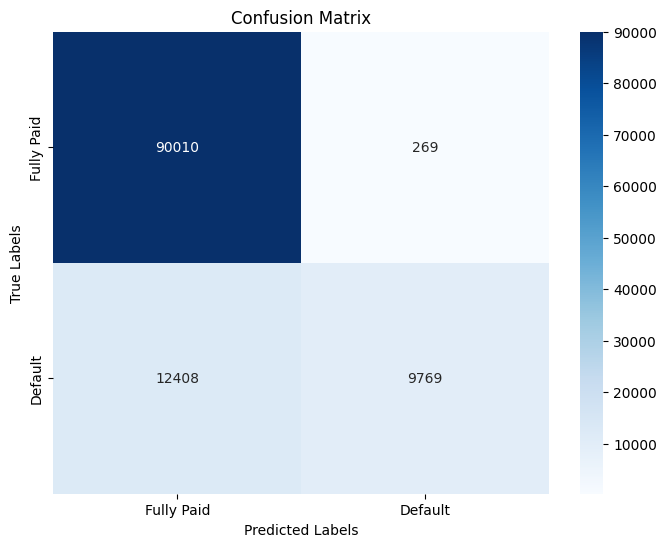

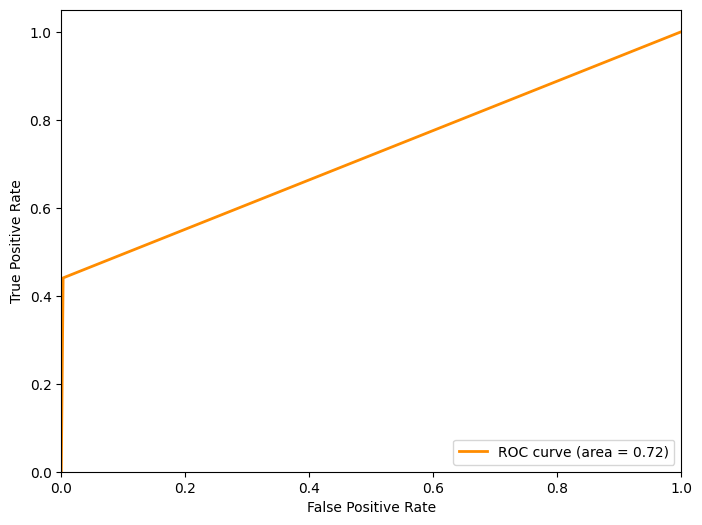

0.4375217684227059


In [39]:
y_pred_op_f1 = (y_test_pred_f1 > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred_op_f1)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Fully Paid', 'Default'])
ax.yaxis.set_ticklabels(['Fully Paid', 'Default'])
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_test_pred_f1)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_f1)

# Calculate Kolmogorov-Smirnov measure (KS)
ks = max(tpr - fpr)

print(ks)

## AUC: PRC

In [40]:
auprc_scorer = make_scorer(average_precision_score, needs_proba=True)

nn_tuning_prc = RandomizedSearchCV(estimator=pipeline,
                                   param_distributions=param_grid,
                                   n_iter=8,
                                   cv=3,
                                   random_state=42,
                                   scoring=auprc_scorer)

r_nn_tuning_prc= nn_tuning_prc.fit(X_train_minmax, y_train)

c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
4659/4659 - 4s - 813us/step - AUC: 0.7750 - loss: 0.3940
Epoch 2/20
4659/4659 - 3s - 655us/step - AUC: 0.7860 - loss: 0.3765
Epoch 3/20
4659/4659 - 3s - 651us/step - AUC: 0.7982 - loss: 0.3670
Epoch 4/20
4659/4659 - 3s - 654us/step - AUC: 0.8177 - loss: 0.3531
Epoch 5/20
4659/4659 - 3s - 648us/step - AUC: 0.8203 - loss: 0.3508
Epoch 6/20
4659/4659 - 3s - 653us/step - AUC: 0.8196 - loss: 0.3507
Epoch 7/20
4659/4659 - 3s - 655us/step - AUC: 0.8192 - loss: 0.3506
Epoch 8/20
4659/4659 - 3s - 654us/step - AUC: 0.8209 - loss: 0.3501
Epoch 9/20
4659/4659 - 3s - 657us/step - AUC: 0.8195 - loss: 0.3502
Epoch 10/20
4659/4659 - 3s - 650us/step - AUC: 0.8206 - loss: 0.3500
Epoch 11/20
4659/4659 - 3s - 658us/step - AUC: 0.8203 - loss: 0.3501
Epoch 12/20
4659/4659 - 3s - 652us/step - AUC: 0.8203 - loss: 0.3499
Epoch 13/20
4659/4659 - 3s - 658us/step - AUC: 0.8187 - loss: 0.3504
Epoch 14/20
4659/4659 - 3s - 658us/step - AUC: 0.8198 - loss: 0.3503
Epoch 15/20
4659/4659 - 3s - 665us/step - A

c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4659/4659 - 4s - 806us/step - AUC: 0.7749 - loss: 0.3933
Epoch 2/20
4659/4659 - 3s - 664us/step - AUC: 0.7859 - loss: 0.3765
Epoch 3/20
4659/4659 - 3s - 658us/step - AUC: 0.7968 - loss: 0.3689
Epoch 4/20
4659/4659 - 3s - 663us/step - AUC: 0.8122 - loss: 0.3564
Epoch 5/20
4659/4659 - 3s - 657us/step - AUC: 0.8170 - loss: 0.3525
Epoch 6/20
4659/4659 - 3s - 663us/step - AUC: 0.8175 - loss: 0.3521
Epoch 7/20
4659/4659 - 3s - 654us/step - AUC: 0.8205 - loss: 0.3501
Epoch 8/20
4659/4659 - 3s - 658us/step - AUC: 0.8262 - loss: 0.3463
Epoch 9/20
4659/4659 - 3s - 658us/step - AUC: 0.8279 - loss: 0.3444
Epoch 10/20
4659/4659 - 3s - 660us/step - AUC: 0.8278 - loss: 0.3446
Epoch 11/20
4659/4659 - 3s - 659us/step - AUC: 0.8276 - loss: 0.3448
Epoch 12/20
4659/4659 - 3s - 661us/step - AUC: 0.8296 - loss: 0.3429
Epoch 13/20
4659/4659 - 3s - 662us/step - AUC: 0.8280 - loss: 0.3440
Epoch 14/20
4659/4659 - 3s - 668us/step - AUC: 0.8289 - loss: 0.3427
Epoch 15/20
4659/4659 - 3s - 664us/step - AUC: 0.8286 

c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4659/4659 - 4s - 820us/step - AUC: 0.7748 - loss: 0.3936
Epoch 2/20
4659/4659 - 3s - 669us/step - AUC: 0.7915 - loss: 0.3730
Epoch 3/20
4659/4659 - 3s - 660us/step - AUC: 0.8177 - loss: 0.3532
Epoch 4/20
4659/4659 - 3s - 668us/step - AUC: 0.8216 - loss: 0.3494
Epoch 5/20
4659/4659 - 3s - 677us/step - AUC: 0.8228 - loss: 0.3489
Epoch 6/20
4659/4659 - 3s - 670us/step - AUC: 0.8238 - loss: 0.3485
Epoch 7/20
4659/4659 - 3s - 667us/step - AUC: 0.8230 - loss: 0.3482
Epoch 8/20
4659/4659 - 3s - 656us/step - AUC: 0.8229 - loss: 0.3480
Epoch 9/20
4659/4659 - 3s - 660us/step - AUC: 0.8215 - loss: 0.3489
Epoch 10/20
4659/4659 - 3s - 659us/step - AUC: 0.8222 - loss: 0.3486
Epoch 11/20
4659/4659 - 3s - 665us/step - AUC: 0.8219 - loss: 0.3480
Epoch 12/20
4659/4659 - 3s - 659us/step - AUC: 0.8237 - loss: 0.3477
Epoch 13/20
4659/4659 - 3s - 652us/step - AUC: 0.8209 - loss: 0.3500
Epoch 14/20
4659/4659 - 3s - 677us/step - AUC: 0.8207 - loss: 0.3500
Epoch 15/20
4659/4659 - 3s - 656us/step - AUC: 0.8208 

c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4659/4659 - 4s - 761us/step - AUC: 0.7405 - loss: 0.4369
Epoch 2/20
4659/4659 - 2s - 523us/step - AUC: 0.7808 - loss: 0.3926
Epoch 3/20
4659/4659 - 2s - 515us/step - AUC: 0.7883 - loss: 0.3787
Epoch 4/20
4659/4659 - 2s - 521us/step - AUC: 0.7922 - loss: 0.3747
Epoch 5/20
4659/4659 - 2s - 512us/step - AUC: 0.7943 - loss: 0.3716
Epoch 6/20
4659/4659 - 2s - 519us/step - AUC: 0.8058 - loss: 0.3653
Epoch 7/20
4659/4659 - 2s - 513us/step - AUC: 0.8204 - loss: 0.3542
Epoch 8/20
4659/4659 - 2s - 520us/step - AUC: 0.8239 - loss: 0.3506
Epoch 9/20
4659/4659 - 2s - 523us/step - AUC: 0.8256 - loss: 0.3485
Epoch 10/20
4659/4659 - 2s - 518us/step - AUC: 0.8255 - loss: 0.3478
Epoch 11/20
4659/4659 - 2s - 515us/step - AUC: 0.8265 - loss: 0.3474
Epoch 12/20
4659/4659 - 2s - 517us/step - AUC: 0.8256 - loss: 0.3479
Epoch 13/20
4659/4659 - 2s - 519us/step - AUC: 0.8270 - loss: 0.3469
Epoch 14/20
4659/4659 - 2s - 518us/step - AUC: 0.8273 - loss: 0.3466
Epoch 15/20
4659/4659 - 2s - 516us/step - AUC: 0.8271 

c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4659/4659 - 3s - 668us/step - AUC: 0.7124 - loss: 0.4531
Epoch 2/20
4659/4659 - 2s - 523us/step - AUC: 0.7771 - loss: 0.3897
Epoch 3/20
4659/4659 - 2s - 518us/step - AUC: 0.7870 - loss: 0.3754
Epoch 4/20
4659/4659 - 2s - 525us/step - AUC: 0.7906 - loss: 0.3723
Epoch 5/20
4659/4659 - 2s - 527us/step - AUC: 0.7980 - loss: 0.3691
Epoch 6/20
4659/4659 - 2s - 521us/step - AUC: 0.8118 - loss: 0.3611
Epoch 7/20
4659/4659 - 2s - 520us/step - AUC: 0.8207 - loss: 0.3533
Epoch 8/20
4659/4659 - 2s - 528us/step - AUC: 0.8213 - loss: 0.3509
Epoch 9/20
4659/4659 - 2s - 517us/step - AUC: 0.8219 - loss: 0.3501
Epoch 10/20
4659/4659 - 2s - 521us/step - AUC: 0.8223 - loss: 0.3491
Epoch 11/20
4659/4659 - 2s - 518us/step - AUC: 0.8220 - loss: 0.3494
Epoch 12/20
4659/4659 - 3s - 539us/step - AUC: 0.8230 - loss: 0.3479
Epoch 13/20
4659/4659 - 2s - 526us/step - AUC: 0.8242 - loss: 0.3475
Epoch 14/20
4659/4659 - 2s - 530us/step - AUC: 0.8240 - loss: 0.3469
Epoch 15/20
4659/4659 - 2s - 523us/step - AUC: 0.8242 

c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4659/4659 - 3s - 675us/step - AUC: 0.7324 - loss: 0.4395
Epoch 2/20
4659/4659 - 2s - 523us/step - AUC: 0.7797 - loss: 0.3901
Epoch 3/20
4659/4659 - 2s - 515us/step - AUC: 0.7891 - loss: 0.3755
Epoch 4/20
4659/4659 - 2s - 519us/step - AUC: 0.7963 - loss: 0.3705
Epoch 5/20
4659/4659 - 2s - 515us/step - AUC: 0.8083 - loss: 0.3613
Epoch 6/20
4659/4659 - 2s - 519us/step - AUC: 0.8106 - loss: 0.3591
Epoch 7/20
4659/4659 - 2s - 517us/step - AUC: 0.8114 - loss: 0.3575
Epoch 8/20
4659/4659 - 2s - 526us/step - AUC: 0.8139 - loss: 0.3554
Epoch 9/20
4659/4659 - 2s - 516us/step - AUC: 0.8149 - loss: 0.3552
Epoch 10/20
4659/4659 - 2s - 516us/step - AUC: 0.8150 - loss: 0.3551
Epoch 11/20
4659/4659 - 2s - 520us/step - AUC: 0.8228 - loss: 0.3507
Epoch 12/20
4659/4659 - 2s - 522us/step - AUC: 0.8256 - loss: 0.3483
Epoch 13/20
4659/4659 - 2s - 523us/step - AUC: 0.8274 - loss: 0.3463
Epoch 14/20
4659/4659 - 2s - 518us/step - AUC: 0.8274 - loss: 0.3460
Epoch 15/20
4659/4659 - 2s - 522us/step - AUC: 0.8273 

c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4659/4659 - 3s - 733us/step - AUC: 0.7760 - loss: 0.3933
Epoch 2/20
4659/4659 - 3s - 589us/step - AUC: 0.7919 - loss: 0.3733
Epoch 3/20
4659/4659 - 3s - 587us/step - AUC: 0.8161 - loss: 0.3545
Epoch 4/20
4659/4659 - 3s - 597us/step - AUC: 0.8183 - loss: 0.3516
Epoch 5/20
4659/4659 - 3s - 581us/step - AUC: 0.8180 - loss: 0.3508
Epoch 6/20
4659/4659 - 3s - 585us/step - AUC: 0.8198 - loss: 0.3507
Epoch 7/20
4659/4659 - 3s - 593us/step - AUC: 0.8217 - loss: 0.3486
Epoch 8/20
4659/4659 - 3s - 587us/step - AUC: 0.8198 - loss: 0.3504
Epoch 9/20
4659/4659 - 3s - 582us/step - AUC: 0.8208 - loss: 0.3490
Epoch 10/20
4659/4659 - 3s - 590us/step - AUC: 0.8216 - loss: 0.3492
Epoch 11/20
4659/4659 - 3s - 580us/step - AUC: 0.8199 - loss: 0.3499
Epoch 12/20
4659/4659 - 3s - 587us/step - AUC: 0.8213 - loss: 0.3491
Epoch 13/20
4659/4659 - 3s - 576us/step - AUC: 0.8199 - loss: 0.3498
Epoch 14/20
4659/4659 - 3s - 581us/step - AUC: 0.8214 - loss: 0.3489
Epoch 15/20
4659/4659 - 3s - 582us/step - AUC: 0.8209 

c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4659/4659 - 3s - 732us/step - AUC: 0.7744 - loss: 0.3965
Epoch 2/20
4659/4659 - 3s - 590us/step - AUC: 0.7864 - loss: 0.3768
Epoch 3/20
4659/4659 - 3s - 567us/step - AUC: 0.7883 - loss: 0.3743
Epoch 4/20
4659/4659 - 3s - 578us/step - AUC: 0.8138 - loss: 0.3562
Epoch 5/20
4659/4659 - 3s - 584us/step - AUC: 0.8272 - loss: 0.3467
Epoch 6/20
4659/4659 - 3s - 579us/step - AUC: 0.8329 - loss: 0.3414
Epoch 7/20
4659/4659 - 3s - 585us/step - AUC: 0.8317 - loss: 0.3417
Epoch 8/20
4659/4659 - 3s - 569us/step - AUC: 0.8328 - loss: 0.3406
Epoch 9/20
4659/4659 - 3s - 573us/step - AUC: 0.8315 - loss: 0.3431
Epoch 10/20
4659/4659 - 3s - 578us/step - AUC: 0.8335 - loss: 0.3407
Epoch 11/20
4659/4659 - 3s - 571us/step - AUC: 0.8335 - loss: 0.3404
Epoch 12/20
4659/4659 - 3s - 568us/step - AUC: 0.8344 - loss: 0.3403
Epoch 13/20
4659/4659 - 3s - 568us/step - AUC: 0.8340 - loss: 0.3397
Epoch 14/20
4659/4659 - 3s - 566us/step - AUC: 0.8348 - loss: 0.3394
Epoch 15/20
4659/4659 - 3s - 571us/step - AUC: 0.8340 

c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4659/4659 - 3s - 716us/step - AUC: 0.7745 - loss: 0.3948
Epoch 2/20
4659/4659 - 3s - 579us/step - AUC: 0.7834 - loss: 0.3793
Epoch 3/20
4659/4659 - 3s - 577us/step - AUC: 0.7911 - loss: 0.3731
Epoch 4/20
4659/4659 - 3s - 574us/step - AUC: 0.8143 - loss: 0.3557
Epoch 5/20
4659/4659 - 3s - 574us/step - AUC: 0.8175 - loss: 0.3525
Epoch 6/20
4659/4659 - 3s - 572us/step - AUC: 0.8187 - loss: 0.3521
Epoch 7/20
4659/4659 - 3s - 590us/step - AUC: 0.8189 - loss: 0.3516
Epoch 8/20
4659/4659 - 3s - 579us/step - AUC: 0.8193 - loss: 0.3509
Epoch 9/20
4659/4659 - 3s - 581us/step - AUC: 0.8196 - loss: 0.3509
Epoch 10/20
4659/4659 - 3s - 570us/step - AUC: 0.8182 - loss: 0.3511
Epoch 11/20
4659/4659 - 3s - 575us/step - AUC: 0.8188 - loss: 0.3505
Epoch 12/20
4659/4659 - 3s - 585us/step - AUC: 0.8192 - loss: 0.3509
Epoch 13/20
4659/4659 - 3s - 576us/step - AUC: 0.8195 - loss: 0.3505
Epoch 14/20
4659/4659 - 3s - 586us/step - AUC: 0.8201 - loss: 0.3511
Epoch 15/20
4659/4659 - 3s - 577us/step - AUC: 0.8199 

c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4659/4659 - 4s - 809us/step - AUC: 0.7766 - loss: 0.3961
Epoch 2/20
4659/4659 - 3s - 666us/step - AUC: 0.7988 - loss: 0.3659
Epoch 3/20
4659/4659 - 3s - 673us/step - AUC: 0.8034 - loss: 0.3618
Epoch 4/20
4659/4659 - 3s - 677us/step - AUC: 0.8272 - loss: 0.3459
Epoch 5/20
4659/4659 - 3s - 675us/step - AUC: 0.8503 - loss: 0.3276
Epoch 6/20
4659/4659 - 3s - 677us/step - AUC: 0.8668 - loss: 0.3122
Epoch 7/20
4659/4659 - 3s - 664us/step - AUC: 0.8714 - loss: 0.3057
Epoch 8/20
4659/4659 - 3s - 668us/step - AUC: 0.8754 - loss: 0.3005
Epoch 9/20
4659/4659 - 3s - 672us/step - AUC: 0.8753 - loss: 0.2988
Epoch 10/20
4659/4659 - 3s - 672us/step - AUC: 0.8765 - loss: 0.2964
Epoch 11/20
4659/4659 - 3s - 672us/step - AUC: 0.8769 - loss: 0.2946
Epoch 12/20
4659/4659 - 3s - 669us/step - AUC: 0.8782 - loss: 0.2926
Epoch 13/20
4659/4659 - 3s - 677us/step - AUC: 0.8788 - loss: 0.2917
Epoch 14/20
4659/4659 - 3s - 658us/step - AUC: 0.8787 - loss: 0.2915
Epoch 15/20
4659/4659 - 3s - 660us/step - AUC: 0.8803 

c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4659/4659 - 4s - 812us/step - AUC: 0.7772 - loss: 0.3974
Epoch 2/20
4659/4659 - 3s - 666us/step - AUC: 0.7980 - loss: 0.3668
Epoch 3/20
4659/4659 - 3s - 664us/step - AUC: 0.8015 - loss: 0.3629
Epoch 4/20
4659/4659 - 3s - 662us/step - AUC: 0.8240 - loss: 0.3486
Epoch 5/20
4659/4659 - 3s - 670us/step - AUC: 0.8482 - loss: 0.3295
Epoch 6/20
4659/4659 - 3s - 669us/step - AUC: 0.8593 - loss: 0.3209
Epoch 7/20
4659/4659 - 3s - 663us/step - AUC: 0.8632 - loss: 0.3164
Epoch 8/20
4659/4659 - 3s - 671us/step - AUC: 0.8660 - loss: 0.3130
Epoch 9/20
4659/4659 - 3s - 664us/step - AUC: 0.8703 - loss: 0.3071
Epoch 10/20
4659/4659 - 3s - 660us/step - AUC: 0.8731 - loss: 0.3007
Epoch 11/20
4659/4659 - 3s - 668us/step - AUC: 0.8751 - loss: 0.2959
Epoch 12/20
4659/4659 - 3s - 660us/step - AUC: 0.8781 - loss: 0.2929
Epoch 13/20
4659/4659 - 3s - 657us/step - AUC: 0.8785 - loss: 0.2914
Epoch 14/20
4659/4659 - 3s - 663us/step - AUC: 0.8793 - loss: 0.2908
Epoch 15/20
4659/4659 - 3s - 667us/step - AUC: 0.8805 

c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4659/4659 - 4s - 815us/step - AUC: 0.7778 - loss: 0.3962
Epoch 2/20
4659/4659 - 3s - 679us/step - AUC: 0.7977 - loss: 0.3665
Epoch 3/20
4659/4659 - 3s - 671us/step - AUC: 0.8010 - loss: 0.3629
Epoch 4/20
4659/4659 - 3s - 670us/step - AUC: 0.8144 - loss: 0.3542
Epoch 5/20
4659/4659 - 3s - 663us/step - AUC: 0.8394 - loss: 0.3359
Epoch 6/20
4659/4659 - 3s - 670us/step - AUC: 0.8511 - loss: 0.3274
Epoch 7/20
4659/4659 - 3s - 665us/step - AUC: 0.8626 - loss: 0.3175
Epoch 8/20
4659/4659 - 3s - 664us/step - AUC: 0.8660 - loss: 0.3129
Epoch 9/20
4659/4659 - 3s - 672us/step - AUC: 0.8695 - loss: 0.3077
Epoch 10/20
4659/4659 - 3s - 674us/step - AUC: 0.8725 - loss: 0.3033
Epoch 11/20
4659/4659 - 3s - 664us/step - AUC: 0.8742 - loss: 0.3005
Epoch 12/20
4659/4659 - 3s - 685us/step - AUC: 0.8753 - loss: 0.2982
Epoch 13/20
4659/4659 - 3s - 661us/step - AUC: 0.8750 - loss: 0.2980
Epoch 14/20
4659/4659 - 3s - 673us/step - AUC: 0.8765 - loss: 0.2956
Epoch 15/20
4659/4659 - 3s - 677us/step - AUC: 0.8777 

c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4659/4659 - 3s - 674us/step - AUC: 0.7702 - loss: 0.4007
Epoch 2/20
4659/4659 - 2s - 529us/step - AUC: 0.7841 - loss: 0.3811
Epoch 3/20
4659/4659 - 2s - 520us/step - AUC: 0.7866 - loss: 0.3790
Epoch 4/20
4659/4659 - 2s - 527us/step - AUC: 0.8115 - loss: 0.3609
Epoch 5/20
4659/4659 - 2s - 533us/step - AUC: 0.8149 - loss: 0.3571
Epoch 6/20
4659/4659 - 2s - 524us/step - AUC: 0.8153 - loss: 0.3572
Epoch 7/20
4659/4659 - 2s - 522us/step - AUC: 0.8147 - loss: 0.3565
Epoch 8/20
4659/4659 - 2s - 518us/step - AUC: 0.8161 - loss: 0.3559
Epoch 9/20
4659/4659 - 2s - 517us/step - AUC: 0.8159 - loss: 0.3557
Epoch 10/20
4659/4659 - 2s - 514us/step - AUC: 0.8160 - loss: 0.3554
Epoch 11/20
4659/4659 - 2s - 516us/step - AUC: 0.8177 - loss: 0.3542
Epoch 12/20
4659/4659 - 2s - 514us/step - AUC: 0.8168 - loss: 0.3555
Epoch 13/20
4659/4659 - 2s - 523us/step - AUC: 0.8156 - loss: 0.3557
Epoch 14/20
4659/4659 - 2s - 519us/step - AUC: 0.8173 - loss: 0.3546
Epoch 15/20
4659/4659 - 2s - 527us/step - AUC: 0.8171 

c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4659/4659 - 3s - 656us/step - AUC: 0.7723 - loss: 0.3981
Epoch 2/20
4659/4659 - 2s - 516us/step - AUC: 0.7861 - loss: 0.3788
Epoch 3/20
4659/4659 - 2s - 515us/step - AUC: 0.8063 - loss: 0.3628
Epoch 4/20
4659/4659 - 2s - 509us/step - AUC: 0.8171 - loss: 0.3546
Epoch 5/20
4659/4659 - 2s - 514us/step - AUC: 0.8173 - loss: 0.3540
Epoch 6/20
4659/4659 - 3s - 542us/step - AUC: 0.8170 - loss: 0.3540
Epoch 7/20
4659/4659 - 2s - 512us/step - AUC: 0.8183 - loss: 0.3525
Epoch 8/20
4659/4659 - 2s - 516us/step - AUC: 0.8188 - loss: 0.3529
Epoch 9/20
4659/4659 - 2s - 519us/step - AUC: 0.8194 - loss: 0.3518
Epoch 10/20
4659/4659 - 2s - 520us/step - AUC: 0.8214 - loss: 0.3495
Epoch 11/20
4659/4659 - 2s - 524us/step - AUC: 0.8207 - loss: 0.3504
Epoch 12/20
4659/4659 - 2s - 527us/step - AUC: 0.8198 - loss: 0.3505
Epoch 13/20
4659/4659 - 2s - 526us/step - AUC: 0.8198 - loss: 0.3511
Epoch 14/20
4659/4659 - 2s - 528us/step - AUC: 0.8202 - loss: 0.3509
Epoch 15/20
4659/4659 - 2s - 531us/step - AUC: 0.8211 

c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4659/4659 - 3s - 648us/step - AUC: 0.7630 - loss: 0.4164
Epoch 2/20
4659/4659 - 2s - 515us/step - AUC: 0.7751 - loss: 0.4039
Epoch 3/20
4659/4659 - 2s - 515us/step - AUC: 0.7867 - loss: 0.3964
Epoch 4/20
4659/4659 - 2s - 525us/step - AUC: 0.8004 - loss: 0.3841
Epoch 5/20
4659/4659 - 2s - 516us/step - AUC: 0.8002 - loss: 0.3839
Epoch 6/20
4659/4659 - 2s - 513us/step - AUC: 0.8016 - loss: 0.3838
Epoch 7/20
4659/4659 - 2s - 514us/step - AUC: 0.8016 - loss: 0.3833
Epoch 8/20
4659/4659 - 2s - 517us/step - AUC: 0.8014 - loss: 0.3835
Epoch 9/20
4659/4659 - 2s - 518us/step - AUC: 0.8038 - loss: 0.3821
Epoch 10/20
4659/4659 - 2s - 521us/step - AUC: 0.8018 - loss: 0.3833
Epoch 11/20
4659/4659 - 2s - 516us/step - AUC: 0.8022 - loss: 0.3828
Epoch 12/20
4659/4659 - 2s - 517us/step - AUC: 0.8038 - loss: 0.3818
Epoch 13/20
4659/4659 - 2s - 512us/step - AUC: 0.8026 - loss: 0.3823
Epoch 14/20
4659/4659 - 2s - 513us/step - AUC: 0.8011 - loss: 0.3838
Epoch 15/20
4659/4659 - 2s - 522us/step - AUC: 0.8027 

c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4659/4659 - 3s - 676us/step - AUC: 0.7518 - loss: 0.4224
Epoch 2/20
4659/4659 - 3s - 539us/step - AUC: 0.7681 - loss: 0.3994
Epoch 3/20
4659/4659 - 2s - 532us/step - AUC: 0.7689 - loss: 0.3975
Epoch 4/20
4659/4659 - 3s - 537us/step - AUC: 0.7699 - loss: 0.3965
Epoch 5/20
4659/4659 - 2s - 531us/step - AUC: 0.7700 - loss: 0.3956
Epoch 6/20
4659/4659 - 2s - 532us/step - AUC: 0.7838 - loss: 0.3862
Epoch 7/20
4659/4659 - 2s - 535us/step - AUC: 0.7883 - loss: 0.3820
Epoch 8/20
4659/4659 - 3s - 558us/step - AUC: 0.7921 - loss: 0.3799
Epoch 9/20
4659/4659 - 3s - 549us/step - AUC: 0.7978 - loss: 0.3757
Epoch 10/20
4659/4659 - 2s - 535us/step - AUC: 0.7979 - loss: 0.3736
Epoch 11/20
4659/4659 - 2s - 533us/step - AUC: 0.7988 - loss: 0.3738
Epoch 12/20
4659/4659 - 2s - 528us/step - AUC: 0.7981 - loss: 0.3730
Epoch 13/20
4659/4659 - 3s - 552us/step - AUC: 0.7953 - loss: 0.3754
Epoch 14/20
4659/4659 - 3s - 537us/step - AUC: 0.7988 - loss: 0.3720
Epoch 15/20
4659/4659 - 3s - 540us/step - AUC: 0.7969 

c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4659/4659 - 4s - 787us/step - AUC: 0.7529 - loss: 0.4199
Epoch 2/20
4659/4659 - 2s - 531us/step - AUC: 0.7669 - loss: 0.4008
Epoch 3/20
4659/4659 - 2s - 535us/step - AUC: 0.7678 - loss: 0.3978
Epoch 4/20
4659/4659 - 2s - 534us/step - AUC: 0.7697 - loss: 0.3968
Epoch 5/20
4659/4659 - 3s - 539us/step - AUC: 0.7686 - loss: 0.3973
Epoch 6/20
4659/4659 - 3s - 544us/step - AUC: 0.7702 - loss: 0.3956
Epoch 7/20
4659/4659 - 3s - 542us/step - AUC: 0.7788 - loss: 0.3909
Epoch 8/20
4659/4659 - 2s - 535us/step - AUC: 0.7865 - loss: 0.3846
Epoch 9/20
4659/4659 - 3s - 544us/step - AUC: 0.7890 - loss: 0.3808
Epoch 10/20
4659/4659 - 2s - 532us/step - AUC: 0.7877 - loss: 0.3812
Epoch 11/20
4659/4659 - 3s - 546us/step - AUC: 0.7895 - loss: 0.3809
Epoch 12/20
4659/4659 - 3s - 540us/step - AUC: 0.7869 - loss: 0.3817
Epoch 13/20
4659/4659 - 3s - 546us/step - AUC: 0.7858 - loss: 0.3826
Epoch 14/20
4659/4659 - 2s - 534us/step - AUC: 0.7877 - loss: 0.3827
Epoch 15/20
4659/4659 - 3s - 538us/step - AUC: 0.7873 

c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4659/4659 - 3s - 685us/step - AUC: 0.7551 - loss: 0.4174
Epoch 2/20
4659/4659 - 3s - 540us/step - AUC: 0.7674 - loss: 0.3992
Epoch 3/20
4659/4659 - 3s - 550us/step - AUC: 0.7684 - loss: 0.3995
Epoch 4/20
4659/4659 - 3s - 539us/step - AUC: 0.7679 - loss: 0.4000
Epoch 5/20
4659/4659 - 3s - 566us/step - AUC: 0.7668 - loss: 0.3970
Epoch 6/20
4659/4659 - 3s - 548us/step - AUC: 0.7702 - loss: 0.3955
Epoch 7/20
4659/4659 - 3s - 549us/step - AUC: 0.7834 - loss: 0.3849
Epoch 8/20
4659/4659 - 3s - 560us/step - AUC: 0.7857 - loss: 0.3841
Epoch 9/20
4659/4659 - 3s - 552us/step - AUC: 0.7858 - loss: 0.3839
Epoch 10/20
4659/4659 - 3s - 544us/step - AUC: 0.7869 - loss: 0.3828
Epoch 11/20
4659/4659 - 3s - 556us/step - AUC: 0.7864 - loss: 0.3833
Epoch 12/20
4659/4659 - 3s - 545us/step - AUC: 0.7903 - loss: 0.3801
Epoch 13/20
4659/4659 - 3s - 547us/step - AUC: 0.7959 - loss: 0.3755
Epoch 14/20
4659/4659 - 3s - 548us/step - AUC: 0.7923 - loss: 0.3778
Epoch 15/20
4659/4659 - 3s - 543us/step - AUC: 0.7932 

c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4659/4659 - 3s - 676us/step - AUC: 0.7795 - loss: 0.3908
Epoch 2/20
4659/4659 - 3s - 538us/step - AUC: 0.7905 - loss: 0.3745
Epoch 3/20
4659/4659 - 2s - 532us/step - AUC: 0.8143 - loss: 0.3570
Epoch 4/20
4659/4659 - 3s - 537us/step - AUC: 0.8269 - loss: 0.3459
Epoch 5/20
4659/4659 - 2s - 528us/step - AUC: 0.8285 - loss: 0.3451
Epoch 6/20
4659/4659 - 2s - 530us/step - AUC: 0.8293 - loss: 0.3436
Epoch 7/20
4659/4659 - 2s - 529us/step - AUC: 0.8293 - loss: 0.3437
Epoch 8/20
4659/4659 - 2s - 529us/step - AUC: 0.8300 - loss: 0.3436
Epoch 9/20
4659/4659 - 2s - 531us/step - AUC: 0.8290 - loss: 0.3440
Epoch 10/20
4659/4659 - 2s - 527us/step - AUC: 0.8293 - loss: 0.3437
Epoch 11/20
4659/4659 - 2s - 522us/step - AUC: 0.8299 - loss: 0.3426
Epoch 12/20
4659/4659 - 2s - 527us/step - AUC: 0.8304 - loss: 0.3426
Epoch 13/20
4659/4659 - 2s - 527us/step - AUC: 0.8294 - loss: 0.3433
Epoch 14/20
4659/4659 - 2s - 531us/step - AUC: 0.8295 - loss: 0.3433
Epoch 15/20
4659/4659 - 2s - 534us/step - AUC: 0.8308 

c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4659/4659 - 3s - 666us/step - AUC: 0.7787 - loss: 0.3902
Epoch 2/20
4659/4659 - 3s - 539us/step - AUC: 0.8103 - loss: 0.3593
Epoch 3/20
4659/4659 - 3s - 538us/step - AUC: 0.8281 - loss: 0.3455
Epoch 4/20
4659/4659 - 2s - 519us/step - AUC: 0.8309 - loss: 0.3415
Epoch 5/20
4659/4659 - 3s - 539us/step - AUC: 0.8313 - loss: 0.3410
Epoch 6/20
4659/4659 - 2s - 526us/step - AUC: 0.8318 - loss: 0.3411
Epoch 7/20
4659/4659 - 2s - 528us/step - AUC: 0.8327 - loss: 0.3405
Epoch 8/20
4659/4659 - 2s - 530us/step - AUC: 0.8325 - loss: 0.3406
Epoch 9/20
4659/4659 - 2s - 524us/step - AUC: 0.8327 - loss: 0.3403
Epoch 10/20
4659/4659 - 2s - 535us/step - AUC: 0.8329 - loss: 0.3398
Epoch 11/20
4659/4659 - 2s - 534us/step - AUC: 0.8324 - loss: 0.3399
Epoch 12/20
4659/4659 - 2s - 537us/step - AUC: 0.8328 - loss: 0.3394
Epoch 13/20
4659/4659 - 2s - 531us/step - AUC: 0.8325 - loss: 0.3398
Epoch 14/20
4659/4659 - 2s - 530us/step - AUC: 0.8339 - loss: 0.3389
Epoch 15/20
4659/4659 - 2s - 535us/step - AUC: 0.8334 

c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4659/4659 - 3s - 661us/step - AUC: 0.7759 - loss: 0.3955
Epoch 2/20
4659/4659 - 2s - 516us/step - AUC: 0.7868 - loss: 0.3813
Epoch 3/20
4659/4659 - 2s - 519us/step - AUC: 0.7935 - loss: 0.3771
Epoch 4/20
4659/4659 - 2s - 521us/step - AUC: 0.8169 - loss: 0.3588
Epoch 5/20
4659/4659 - 2s - 522us/step - AUC: 0.8193 - loss: 0.3564
Epoch 6/20
4659/4659 - 2s - 515us/step - AUC: 0.8190 - loss: 0.3568
Epoch 7/20
4659/4659 - 2s - 523us/step - AUC: 0.8202 - loss: 0.3557
Epoch 8/20
4659/4659 - 2s - 518us/step - AUC: 0.8203 - loss: 0.3553
Epoch 9/20
4659/4659 - 2s - 523us/step - AUC: 0.8196 - loss: 0.3557
Epoch 10/20
4659/4659 - 2s - 524us/step - AUC: 0.8207 - loss: 0.3550
Epoch 11/20
4659/4659 - 2s - 522us/step - AUC: 0.8201 - loss: 0.3555
Epoch 12/20
4659/4659 - 2s - 521us/step - AUC: 0.8197 - loss: 0.3558
Epoch 13/20
4659/4659 - 2s - 523us/step - AUC: 0.8198 - loss: 0.3551
Epoch 14/20
4659/4659 - 2s - 521us/step - AUC: 0.8210 - loss: 0.3548
Epoch 15/20
4659/4659 - 2s - 525us/step - AUC: 0.8201 

c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4659/4659 - 4s - 819us/step - AUC: 0.7913 - loss: 0.3794
Epoch 2/20
4659/4659 - 3s - 669us/step - AUC: 0.8045 - loss: 0.3601
Epoch 3/20
4659/4659 - 3s - 678us/step - AUC: 0.8088 - loss: 0.3571
Epoch 4/20
4659/4659 - 3s - 671us/step - AUC: 0.8442 - loss: 0.3326
Epoch 5/20
4659/4659 - 3s - 675us/step - AUC: 0.8750 - loss: 0.3015
Epoch 6/20
4659/4659 - 3s - 672us/step - AUC: 0.8833 - loss: 0.2873
Epoch 7/20
4659/4659 - 3s - 671us/step - AUC: 0.8851 - loss: 0.2834
Epoch 8/20
4659/4659 - 3s - 676us/step - AUC: 0.8864 - loss: 0.2811
Epoch 9/20
4659/4659 - 3s - 672us/step - AUC: 0.8869 - loss: 0.2801
Epoch 10/20
4659/4659 - 3s - 665us/step - AUC: 0.8880 - loss: 0.2786
Epoch 11/20
4659/4659 - 3s - 665us/step - AUC: 0.8891 - loss: 0.2772
Epoch 12/20
4659/4659 - 3s - 673us/step - AUC: 0.8891 - loss: 0.2772
Epoch 13/20
4659/4659 - 3s - 672us/step - AUC: 0.8898 - loss: 0.2769
Epoch 14/20
4659/4659 - 3s - 670us/step - AUC: 0.8906 - loss: 0.2756
Epoch 15/20
4659/4659 - 3s - 669us/step - AUC: 0.8912 

c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4659/4659 - 4s - 822us/step - AUC: 0.7898 - loss: 0.3814
Epoch 2/20
4659/4659 - 3s - 675us/step - AUC: 0.8047 - loss: 0.3604
Epoch 3/20
4659/4659 - 3s - 675us/step - AUC: 0.8352 - loss: 0.3397
Epoch 4/20
4659/4659 - 3s - 672us/step - AUC: 0.8805 - loss: 0.2918
Epoch 5/20
4659/4659 - 3s - 676us/step - AUC: 0.8849 - loss: 0.2831
Epoch 6/20
4659/4659 - 3s - 670us/step - AUC: 0.8858 - loss: 0.2811
Epoch 7/20
4659/4659 - 3s - 679us/step - AUC: 0.8876 - loss: 0.2787
Epoch 8/20
4659/4659 - 3s - 671us/step - AUC: 0.8878 - loss: 0.2784
Epoch 9/20
4659/4659 - 3s - 678us/step - AUC: 0.8890 - loss: 0.2770
Epoch 10/20
4659/4659 - 3s - 666us/step - AUC: 0.8892 - loss: 0.2766
Epoch 11/20
4659/4659 - 3s - 672us/step - AUC: 0.8899 - loss: 0.2764
Epoch 12/20
4659/4659 - 3s - 671us/step - AUC: 0.8906 - loss: 0.2755
Epoch 13/20
4659/4659 - 3s - 669us/step - AUC: 0.8910 - loss: 0.2748
Epoch 14/20
4659/4659 - 3s - 674us/step - AUC: 0.8915 - loss: 0.2747
Epoch 15/20
4659/4659 - 3s - 688us/step - AUC: 0.8922 

c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4659/4659 - 4s - 841us/step - AUC: 0.7897 - loss: 0.3799
Epoch 2/20
4659/4659 - 3s - 686us/step - AUC: 0.8042 - loss: 0.3602
Epoch 3/20
4659/4659 - 3s - 673us/step - AUC: 0.8119 - loss: 0.3554
Epoch 4/20
4659/4659 - 3s - 669us/step - AUC: 0.8625 - loss: 0.3161
Epoch 5/20
4659/4659 - 3s - 676us/step - AUC: 0.8809 - loss: 0.2912
Epoch 6/20
4659/4659 - 3s - 671us/step - AUC: 0.8840 - loss: 0.2843
Epoch 7/20
4659/4659 - 3s - 683us/step - AUC: 0.8868 - loss: 0.2804
Epoch 8/20
4659/4659 - 3s - 670us/step - AUC: 0.8876 - loss: 0.2791
Epoch 9/20
4659/4659 - 3s - 679us/step - AUC: 0.8885 - loss: 0.2777
Epoch 10/20
4659/4659 - 3s - 674us/step - AUC: 0.8892 - loss: 0.2765
Epoch 11/20
4659/4659 - 3s - 672us/step - AUC: 0.8901 - loss: 0.2761
Epoch 12/20
4659/4659 - 3s - 667us/step - AUC: 0.8899 - loss: 0.2757
Epoch 13/20
4659/4659 - 3s - 690us/step - AUC: 0.8910 - loss: 0.2746
Epoch 14/20
4659/4659 - 3s - 668us/step - AUC: 0.8915 - loss: 0.2740
Epoch 15/20
4659/4659 - 3s - 683us/step - AUC: 0.8925 

c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6988/6988 - 5s - 771us/step - AUC: 0.7945 - loss: 0.3742
Epoch 2/20
6988/6988 - 5s - 680us/step - AUC: 0.8188 - loss: 0.3512
Epoch 3/20
6988/6988 - 5s - 665us/step - AUC: 0.8760 - loss: 0.2973
Epoch 4/20
6988/6988 - 5s - 681us/step - AUC: 0.8849 - loss: 0.2815
Epoch 5/20
6988/6988 - 5s - 668us/step - AUC: 0.8857 - loss: 0.2796
Epoch 6/20
6988/6988 - 5s - 669us/step - AUC: 0.8869 - loss: 0.2784
Epoch 7/20
6988/6988 - 5s - 686us/step - AUC: 0.8876 - loss: 0.2774
Epoch 8/20
6988/6988 - 5s - 675us/step - AUC: 0.8882 - loss: 0.2767
Epoch 9/20
6988/6988 - 5s - 686us/step - AUC: 0.8889 - loss: 0.2763
Epoch 10/20
6988/6988 - 5s - 740us/step - AUC: 0.8891 - loss: 0.2757
Epoch 11/20
6988/6988 - 5s - 671us/step - AUC: 0.8896 - loss: 0.2755
Epoch 12/20
6988/6988 - 5s - 684us/step - AUC: 0.8904 - loss: 0.2748
Epoch 13/20
6988/6988 - 5s - 668us/step - AUC: 0.8905 - loss: 0.2745
Epoch 14/20
6988/6988 - 5s - 663us/step - AUC: 0.8910 - loss: 0.2741
Epoch 15/20
6988/6988 - 5s - 681us/step - AUC: 0.8915 

In [ ]:
y_test_pred_prc = nn_tuning_prc.predict(X_test_minmax)
evaluate_nn(y_test, y_test_pred_prc, train=False)

Test Result:
Accuracy Score: 88.67%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.876857      0.992899  0.886738       0.934878       0.899741
recall         0.999247      0.428732  0.886738       0.713990       0.886738
f1-score       0.934060      0.598873  0.886738       0.766466       0.867959
support    90279.000000  22177.000000  0.886738  112456.000000  112456.000000
_______________________________________________
Confusion Matrix: 
 [[90211    68]
 [12669  9508]]

Area Under the Precision-Recall Curve (AUPRC): 0.5383


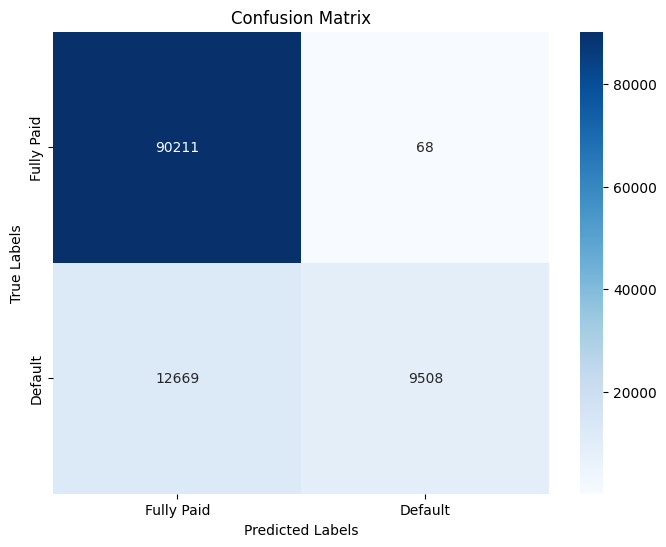

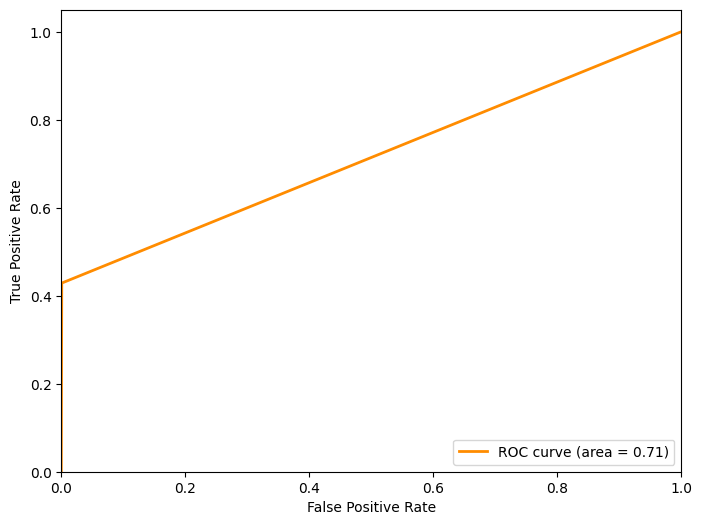

0.42797925000584247


In [ ]:
y_pred_op_f1 = (y_test_pred_prc > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred_op_f1)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Fully Paid', 'Default'])
ax.yaxis.set_ticklabels(['Fully Paid', 'Default'])
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_test_pred_prc)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_prc)

# Calculate Kolmogorov-Smirnov measure (KS)
ks = max(tpr - fpr)

print(ks)

# undersampling with RandomSearchCV

## F1

In [ ]:
pipeline_under = Pipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('classifier', keras_clf)
])

In [ ]:
nn_tuning_f1_under = RandomizedSearchCV(estimator=pipeline_under,
                                   param_distributions=param_grid,
                                   n_iter=10,
                                   cv=3,
                                   random_state=42,
                                   scoring='f1')

r_nn_tuning_f1_under= nn_tuning_f1_under.fit(X_train_minmax, y_train)

c:\Users\winyan\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\winyan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\winyan\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\winyan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\

In [ ]:
y_test_pred_f1_under = nn_tuning_f1_under.predict(X_test_minmax)
evaluate_nn(y_test, y_test_pred_f1_under, train=False)

Test Result:
Accuracy Score: 77.54%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.937520      0.459679  0.775441       0.698600       0.843287
recall         0.771708      0.790639  0.775441       0.781173       0.775441
f1-score       0.846571      0.581356  0.775441       0.713964       0.794269
support    90279.000000  22177.000000  0.775441  112456.000000  112456.000000
_______________________________________________
Confusion Matrix: 
 [[69669 20610]
 [ 4643 17534]]

Area Under the Precision-Recall Curve (AUPRC): 0.4047


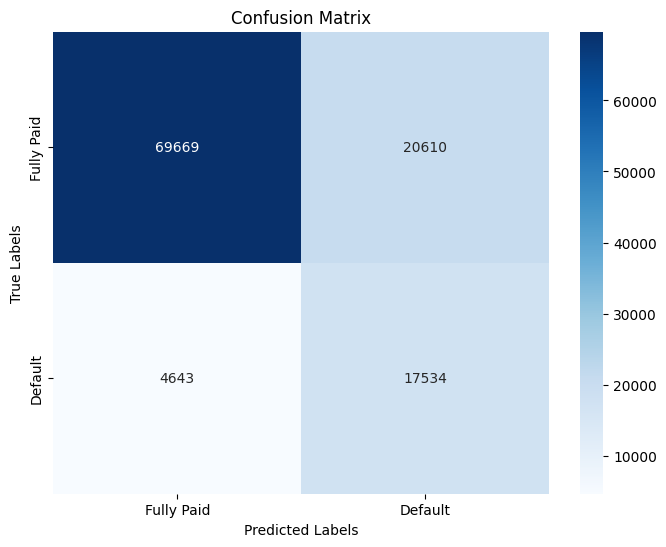

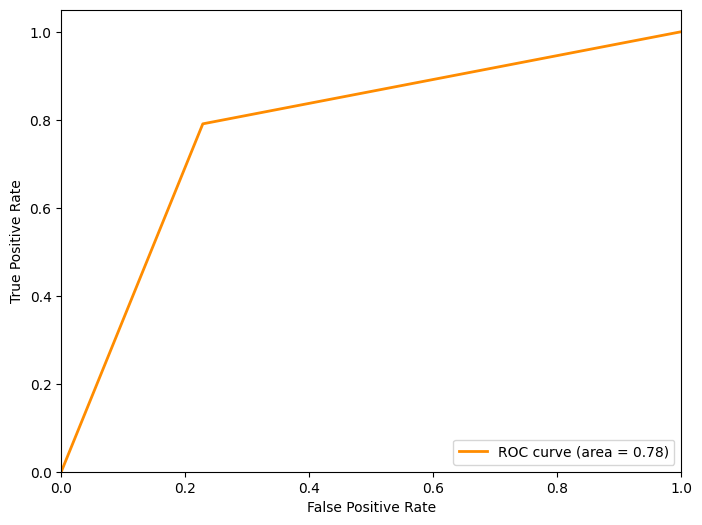

0.5623466563748425


In [ ]:
y_pred_op_f1 = (y_test_pred_f1_under > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred_op_f1)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Fully Paid', 'Default'])
ax.yaxis.set_ticklabels(['Fully Paid', 'Default'])
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_test_pred_f1_under)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_f1_under)

# Calculate Kolmogorov-Smirnov measure (KS)
ks = max(tpr - fpr)

print(ks)

## AUC:PRC

In [ ]:
auprc_scorer = make_scorer(average_precision_score, needs_proba=True)

nn_tuning_prc_under = RandomizedSearchCV(estimator=pipeline_under,
                                   param_distributions=param_grid,
                                   n_iter=10,
                                   cv=3,
                                   random_state=42,
                                   scoring=auprc_scorer)

r_nn_tuning_prc_under = nn_tuning_prc_under.fit(X_train_minmax, y_train)

c:\Users\winyan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
c:\Users\winyan\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\winyan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\winyan

In [ ]:
y_test_pred_prc_under = nn_tuning_prc_under.predict(X_test_minmax)
evaluate_nn(y_test, y_test_pred_prc_under, train=False)

Test Result:
Accuracy Score: 80.15%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.930076      0.497758   0.80146       0.713917       0.844820
recall         0.813877      0.750913   0.80146       0.782395       0.801460
f1-score       0.868105      0.598673   0.80146       0.733389       0.814972
support    90279.000000  22177.000000   0.80146  112456.000000  112456.000000
_______________________________________________
Confusion Matrix: 
 [[73476 16803]
 [ 5524 16653]]

Area Under the Precision-Recall Curve (AUPRC): 0.4229


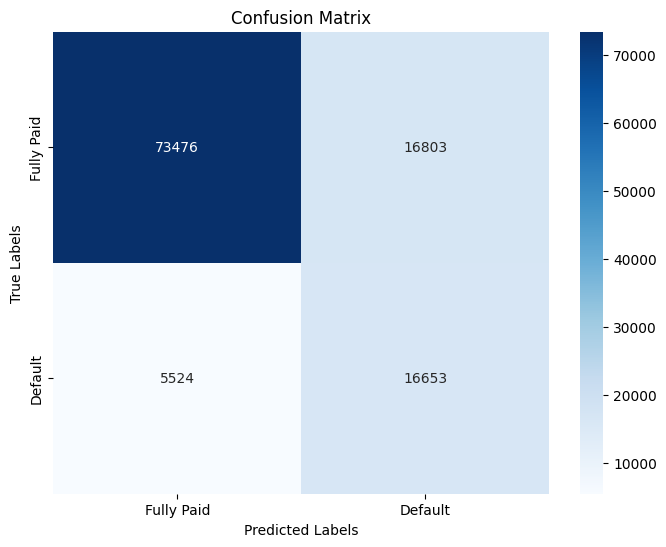

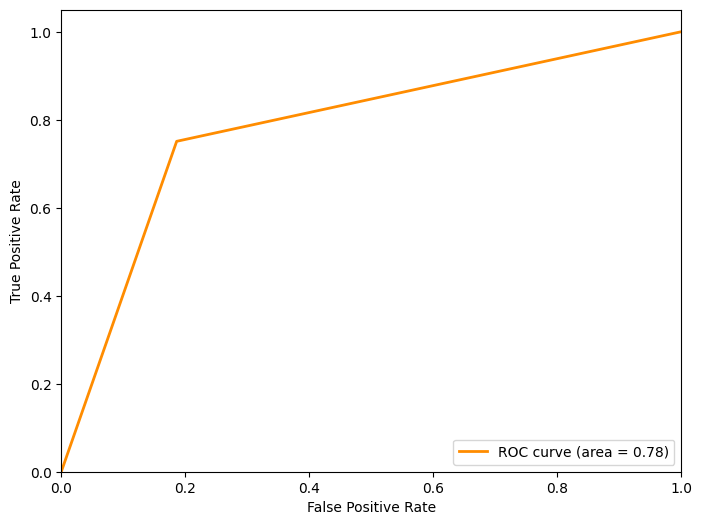

0.5647900895329273


In [ ]:
y_pred_op_f1 = (y_test_pred_prc_under > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred_op_f1)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Fully Paid', 'Default'])
ax.yaxis.set_ticklabels(['Fully Paid', 'Default'])
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_test_pred_prc_under)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_prc_under)

# Calculate Kolmogorov-Smirnov measure (KS)
ks = max(tpr - fpr)

print(ks)